# Проект - анализ проведенного А/А/B теста в дейтинговом приложении

## Содержание

- **[Постановка задачи](#Постановка-задачи)**
- **[0. Импорт библиотек и собственные функции](#0.-Импорт-библиотек-и-собственные-функции)**
- **[1. Загрузка и предобработка данных](#1.-Загрузка-и-предобработка-данных)**
    - [1.1 Первый взгляд на пользователей](#1.1-Первый-взгляд-на-пользователей)
    - [1.2 Первый взгляд на транзакции](#1.2-Первый-взгляд-на-транзакции)
- **[2. Сравнение групп пользователей и исправление недочетов](#2.-Сравнение-групп-пользователей-и-исправление-недочетов)**
- **[3. Обновленные признаки и дополнительные графики для таблиц пользователей](#3.-Обновленные-признаки-и-дополнительные-графики-для-таблиц-пользователей)**
- **[4. Проверка качества сплитования](#4.-Проверка-качества-сплитования)**
- **[5. Гипотезы и тесты](#5.-Гипотезы-и-тесты)**
    - [5.1 Гипотеза о равенстве medianRPPU](#5.1-Гипотеза-о-равенстве-medianRPPU)
    - [5.2 Гипотеза о равенстве дохода с оформления  подписок(не пробных)](#5.2-Гипотеза-о-равенстве-дохода-с-оформления-подписок(не-пробных))
    - [5.3 Гипотеза о равенстве CR в подписку](#5.3-Гипотеза-о-равенстве-CR-в-подписку)
    - [5.4 Гипотеза о равенстве относительной CR из подписки в продление подписки](#5.4-Гипотеза-о-равенстве-относительной-CR-из-подписки-в-продление-подписки)
    - [5.5 Гипотеза о равенстве medianRPPU у пользователей из одних и тех же стран](#5.5-Гипотеза-о-равенстве-medianRPPU-у-пользователей-из-одних-и-тех-же-стран)
    - [5.6 Гипотеза о равенстве medianRPPU у пользователей одних и тех же возрастов и полов](#5.6-Гипотеза-о-равенстве-medianRPPU-у-пользователей-одних-и-тех-же-возрастов-и-полов)
    - [5.7 Гипотеза о равенстве medianRPPU у users с одинаковым количеством дней заходов в приложение](#5.7-Гипотеза-о-равенстве-medianRPPU-у-users-с-одинаковым-количеством-дней-заходов-в-приложение)
- **[6. Итоги и выводы](#6.-Итоги-и-выводы)**
 

## Постановка задачи

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен AА/Б тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

## Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:<br>
#### `users_*.csv` – информация о пользователях:

| |                                                                               |
| :----------------| :-------------------------------------------------------------------------------------|
| uid              | идентификатор пользователя                                                            |
| age              | возраст                                                                               |
| attraction_coeff | коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$ )        |
| coins            | число монеток (внутренняя валюта)                                                     |
| country          | страна                                                                                |
| visit_days       | в какие дни после регистрации пользователь посещал приложение  |
| gender           | пол                                                                                   |
| age_filter_start | фильтр поиска, мин. значение                                                          |
| age_filter_end   | фильтр поиска, макс. значение                                                         |
| views_count      | число полученных оценок                                                               |
| was_premium      | был ли когда-либо премиум (либо пробный премиум, либо купленный за деньги)  |
| is_premium       | является ли премиум                                                                   |
| total_revenue    | нормированная выручка     


#### `transactions_*.csv` – информация о транзакциях:

|                  |                                                                                       |
| :----------------| :-------------------------------------------------------------------------------------|
| uid              | идентификатор пользователя                                                            |
| country          | страна                                                                                |
| joined_at        | дата и время регистрации                                                              |
| paid_at          | дата и время покупки                                                                  |
| revenue          | нормированная выручка                                                                 |
| payment_id       | идентификатор платежа                                                                 |
| from_page        | откуда пользователь перешел на страницу оплаты                                        |
| product_type     | тип продукта*                                                                         |

*trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое 

## 0. Импорт библиотек и собственные функции

In [148]:
import pandas as pd
import numpy as np
import pingouin as pg
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

Используемые функции:

In [149]:
def f_na(df):
    '''Функция заменяет пропущенные значения на более удобные'''
    
    df['coins']       = df.coins.fillna(0)
    df['visit_days']  = df.visit_days.fillna('0')
    df['was_premium'] = df.was_premium.fillna(0)
    df['is_premium']  = df.is_premium.fillna(0)
    return df

In [150]:
def coin_rev_more_0(df):
    '''Функция для подсчета средних и медианных значений coins и total_revenue для соответ. ненулевых знач. пользователей'''
    
    coin_more_0 = df.query('coins > 0').coins
    rev_more_0  = df.query('total_revenue > 0').total_revenue
    print('Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей')
    print(f'Для сoins > 0  ---------> среднее = {round(coin_more_0.mean(), 2)}')
    print(f'                          медиана = {round(coin_more_0.median(), 2)}')
    print(f'Для total_revenue > 0 --> среднее(оно же ARPPU) = {round(rev_more_0.mean(), 2)}')
    print(f'                          медиана(median  RPPU) = {round(rev_more_0.median(), 2)}')

In [151]:
def extended_premium(df):
    ''' Функция для подсчета количества групп людей, взаимодействующих с премиум-подпиской'''
   
    cnt_user = df.shape[0]
    ex_2 = df.query('extended_premium == 2').shape[0]
    ex_1 = df.query('extended_premium == 1').shape[0]
    ex_0 = df.query('extended_premium == 0').shape[0]
    
    print(f'Продлевали премиум     - {ex_2}  пользователя или {round(ex_2 / cnt_user * 100, 2)} %')
    print(f'Не продлевали премиум  - {ex_1}  пользователя или {round(ex_1 / cnt_user * 100, 2)} %')
    print(f'Премиума не было и нет - {ex_0} пользователя или {round(ex_0 / cnt_user * 100, 2)} %')
    print()
    print('Тогда соответсвующие конверсии:')
    print(f'Абсолютная CR в подписку {round((ex_1 + ex_2) / cnt_user * 100, 2)} %')
    print(f'Абсолютная CR в продление подписки {round(ex_2 / cnt_user * 100, 2)} %')

In [152]:
def country_user_plot(df):
    '''Функция строит барчарт c количеством пользователей из разных стран(где больше 10 пользователей)'''
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    sns.barplot(data=df.groupby('country', as_index=False) \
                       .agg({'uid':'count'}).sort_values('uid', ascending=False) \
                       .query('uid > 99'), x='uid', y='country', ax=ax)
    ax.set_xlabel('number of users')
    ax.set_ylabel('country(more than 10 users)')

In [153]:
def country_table(df):
    '''Функция для построения таблицы по странам и подсчета некоторых характеристик для каждой страны'''
    
    df['extended_2'] = df.extended_premium.apply(lambda x: 1 if x == 2 else 0)

    df_c = df.groupby('country', as_index=False) \
           .agg({'uid':'count', 'was_premium':'sum', 'extended_2': 'sum',
                 'age':'mean', 'total_revenue':'mean'}) \
           .rename(columns={'uid':'cnt_users', 'age':'avg_age',
                            'was_premium':'was_premium_per', 'extended_2': 'extended_2_per',
                            'total_revenue':'ARPU'}) \
           .sort_values('cnt_users', ascending=False).query('cnt_users > 99')
    
    df_c.was_premium_per = df_c.was_premium_per / df_c.cnt_users * 100
    df_c.extended_2_per = df_c.extended_2_per / df_c.cnt_users * 100

    avg_total_revenue = df.query('total_revenue > 0') \
                             .groupby('country', as_index=False) \
                             .agg({'total_revenue':'mean'}) \
                             .rename(columns={'total_revenue':'ARPPU'})
    median_total_revenue = df.query('total_revenue > 0') \
                             .groupby('country', as_index=False) \
                             .agg({'total_revenue':'median'}) \
                             .rename(columns={'total_revenue':'median RPPU'})

    df_c = df_c.merge(avg_total_revenue, how='left', on=['country']) \
               .merge(median_total_revenue, how='left', on=['country']) 
    
    
    return df_c.round(2)

In [154]:
def time_frame(df):
    '''Функция для нахождения врменных рамок регистраций и транзакций'''

    print(f"Рамки регистраций пользователей: c {df.joined_at.min().date().strftime('%Y-%m-%d')}") 
    print(f"                                до {df.joined_at.max().date().strftime('%Y-%m-%d')}")
    print()
    print(f"Рамки проведения транзакций:     c {df.paid_at.min().date().strftime('%Y-%m-%d')}")
    print(f"                                до {df.paid_at.max().date().strftime('%Y-%m-%d')}")
    print()

In [155]:
def type_plot(df):
    '''Функция строит 2 барчарта c количеством покупок/заработком с разных транзакций'''
    
    type_plot = df.groupby('product_type', as_index=False).agg({'paid_at':'count', 'revenue':'sum'}) \
                  .rename(columns={'paid_at':'count_type', 'revenue':'sum_type'})
    type_plot['avg_tr'] = type_plot.sum_type / type_plot.count_type
    
    fig, ax = plt.subplots(1, 3, figsize=(26,8), sharey=True)
    
    sns.barplot(data=type_plot.sort_values('product_type', ascending=False), x='count_type', y='product_type', ax=ax[1])
    ax[1].set_title('Количество транзакций')
    ax[1].set_xlabel('count of type')
    ax[1].set_ylabel('')
    
    sns.barplot(data=type_plot.sort_values('product_type', ascending=False), x='sum_type', y='product_type', ax=ax[2])
    ax[2].set_title('Суммарный заработок')
    ax[2].set_xlabel('sum of type')
    ax[2].set_ylabel('')
    
    sns.barplot(data=type_plot.sort_values('product_type', ascending=False), x='avg_tr', y='product_type', ax=ax[0])
    ax[0].set_title('Средний размер транз.')
    ax[0].set_xlabel('avg of type')
    ax[0].set_ylabel('')

In [156]:
def update_total_revenue(transactions, users):
    '''Функция обновляет данные total_revenue пользователей
        в таблицах users по данным из таблиц transactions'''
    
    up_total_revenue = transactions.groupby(['uid'], as_index=False) \
                                .agg({'revenue': 'sum'}).rename(columns={'revenue': 'total_revenue'})
    
    users = users.drop(columns=['total_revenue']) \
                                 .merge(up_total_revenue, on='uid', how='left')
    
    users.total_revenue = users.total_revenue.fillna(0)

In [157]:
def update_premium(transactions, users, col):
    '''Функция обновляет данные was_premium или is_premium пользователей
        в таблицах users по данным из таблиц transactions'''
    
    if col == 'was_premium':
        up_premium = transactions.groupby('uid').product_type.apply(list).to_frame().reset_index()
    elif col == 'is_premium':
        max_time = transactions.paid_at.max().date().strftime('%Y-%m-%d')
        up_premium = transactions.query('paid_at >= "2017-11-12 00:00:00"') \
                                 .groupby('uid').product_type.apply(list).to_frame().reset_index()
        
    up_premium.product_type = up_premium.product_type \
                                 .apply(lambda x: 1 if ('premium_no_trial' in x or 'trial_premium' in x) else 0)
    
    users = users.merge(up_premium, on='uid', how='left')
    
    users.product_type = users.product_type.fillna(0)
    users[col] = users[col] + users.product_type
    users = users.drop(columns=['product_type'])
    
    users[col] = users[col].apply(lambda x: 1 if (x > 0) else 0)

In [158]:
def update_date(transactions, users):
    '''Функция обновляет данные(total_revenue, was_premium, is_premium) пользователей
        в таблицах users по данным из таблиц transactions'''
    
    update_total_revenue(transactions, users)
    update_premium(transactions, users, 'was_premium')
    update_premium(transactions, users, 'is_premium')
    
    users['extended_premium'] = users.was_premium + users.is_premium

In [159]:
def signs_of_groups(data_users):
    '''Функция для проверки равенства дисперсий и проведения ANOVA
       Сначала находим средние велечины в data_users, после чего для их распределений проводим тесты, 
       затем объединяем все в один датафрэйм'''
    
    data_users['from_usa'] = data_users.country.apply(lambda x: 1 if (x == 'United States of America') else 0)
    
    df_sings = data_users.groupby('group', as_index=False).agg({'uid':'count', 'age':'mean', 'attraction_coeff':'mean',
                                                                 'gender':'mean', 'age_filter_start':'mean',
                                                                 'age_filter_end':'mean', 'from_usa':'mean' })
    idx_1 = df_sings.columns.values.tolist()
    
    df_sings = df_sings.round(2) \
                       .rename(columns={'uid_x':'count_users', 'age':'avg_age', 'attraction_coeff':'avg_atr_coeff', 
                                        'gender':'avg_gender', 'age_filter_start':'avg_age_f_start',
                                        'age_filter_end':'avg_age_f_end', 'from_usa':'cnt_from_usa'})
    
    idx_2 = df_sings.columns.values.tolist()
    leven, pair = ['equal_var(leven)', '-->'], ['p-tukey[1-2, 1-t, 2-t]', '-->']
    for i in idx_1[2:]:
        leven.append(round(pg.homoscedasticity(data=data_users, dv=i, group='group', method='levene').pval.values[0], 2))
        pair.append(pg.pairwise_tukey(data=data_users, dv=i, between="group")['p-tukey'].round(2).values.tolist())
        
    test = pd.DataFrame({'3': pd.Series(leven, index=idx_2),
                         '4': pd.Series(pair, index=idx_2)}).T
    
    return pd.concat([df_sings, test])

In [160]:
def get_bootstrap(data_column_1, data_column_2, 
                  statistic = np.median, boot_it = 100000):
    '''Функция для генерации бутрэп-распределений'''
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []

#     for i in tqdm(range(boot_it)):  
    for i in range(boot_it):  
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2))
        
    return boot_data

In [161]:
def get_pvalue(boot_data, bootstrap_conf_level=0.95):
    '''Функция нахождения pvalue и границ доверительного интервала по бутсрэп-распределению'''
    
    p_1 = norm.cdf(x = 0, loc =  np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])
    
    return p_value, ci

In [162]:
def do_boot_median(data_country, col='country', boot_it=100000, bootstrap_conf_level=0.95):
    '''Функция для проверки равенства medianRPPU в тестовой и контрольной группах
       Сначала находим medianRPPU и количество пользователей в data_country,
       после чего для их распределений при помощи бутсрапа проверям гипотезу о равенстве + находим дов. инт., 
       затем объединяем все в один датафрэйм'''
    
    df_country = data_country.groupby([col, 'group'], as_index=False) \
            .agg({'uid':'count', 'total_revenue':'median'}) \
            .groupby(col) \
            .uid.apply(list).to_frame().reset_index() \
            .merge(data_country.groupby([col, 'group'], as_index=False) \
                               .agg({'uid':'count', 'total_revenue':'median'}) \
                               .groupby(col) \
                               .total_revenue.apply(list).to_frame().reset_index(),
            how='left',
            on=[col]) \
            .rename(columns={'uid':'cnt_users[c1, c2, t]', 'total_revenue':'medianRPPU[c1, c2, t]'})
    
    col_names = df_country[col].tolist()
    
    boot_data = {col:col_names, 'control_1':[], 'control_1_ci':[], 'control_2':[], 'control_2_ci':[]}
    for i in col_names:
        b_c1 = data_country.loc[data_country[col] == i].query('group == "control_1"').total_revenue
        b_c2 = data_country.loc[data_country[col] == i].query('group == "control_2"').total_revenue
        b_t = data_country.loc[data_country[col] == i].query('group == "test"').total_revenue
        
        p_ci_1 = get_pvalue(get_bootstrap(b_t, b_c1, statistic = np.median, boot_it=boot_it),
                              bootstrap_conf_level=bootstrap_conf_level)
        p_ci_2 = get_pvalue(get_bootstrap(b_t, b_c2, statistic = np.median, boot_it=boot_it),
                              bootstrap_conf_level=bootstrap_conf_level)
        
        p_cor_1, p_cor_2 = multipletests([p_ci_1[0], p_ci_2[0]], alpha=0.05, method='holm')[1]

        
        boot_data['control_1'].append(round(p_cor_1, 4))
        boot_data['control_1_ci'].append(p_ci_1[1].round(4).values.tolist())
        
        boot_data['control_2'].append(round(p_cor_2, 4))
        boot_data['control_2_ci'].append(p_ci_2[1].round(4).values.tolist())
            
    return df_country.merge(pd.DataFrame.from_dict(boot_data),
                                   how='left', on=[col]) \
                            .rename(columns={'control_1':'p-val [t, c1]', 'control_1_ci':'ci [t, c1]',
                                             'control_2':'p-val [t, c2]', 'control_2_ci':'ci [t, c2]'})

In [163]:
def data_sub():
    '''Функция для выделения групп пользователей для проверки гипотезы о равенстве 
              в тесте и контролях медианного дохода с подписок на пользователя'''
    
    data_sub = data_transactions.query('product_type == "premium_no_trial"') \
                                .groupby('uid', as_index=False).agg({'revenue':'sum'})

    data_users['age_group'] = pd.cut(data_users.age, [0, 19, 25, 30, 35, 40, 50, 100],
                                labels=['16-19', '20-25', '26-30', '31-35', '36-40', '41-50', '51-99'])

    data_users['group_days'] = pd.cut(data_users.cnt_visit_days, [-1, 0.5, 3, 7.5, 14.5, 21.5, 31],
                                      labels=['0', '1-3', '4-7', '8-14', '15-21', '22-31'])

    df = data_sub[['uid','revenue']].merge(data_users[['uid', 'group_days', 'group', 'age_group']],
                                                  how='left', on=['uid']) \
                                           .rename(columns={'revenue':'prem_rev'})

    df = df.astype({'group_days': 'str', 'age_group':'str'})
    df['description'] = '[' + df.group_days + 'd]' + '[' + df.age_group + 'y]'
    
    return df[['uid', 'description', 'group', 'prem_rev']]

## 1. Загрузка и предобработка данных

#### Загрузим все имеющиеся данные

In [164]:
users_control_1 = pd.read_csv('3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('3_users_control_2.csv', sep=';')
users_test      = pd.read_csv('3_users_test.csv', sep=';')

transactions_control_1 = pd.read_csv('3_transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_2 = pd.read_csv('3_transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_test      = pd.read_csv('3_transactions_test.csv',      sep=';', parse_dates=['joined_at', 'paid_at'])

### 1.1 Первый взгляд на пользователей
[Содержание](#Содержание)

#### Первая контрольная группа:

In [165]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [166]:
users_control_1.shape

(4340, 13)

In [167]:
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [168]:
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [169]:
users_control_1.was_premium.unique(), users_control_1.is_premium.unique(),       

(array([nan,  1.]), array([nan,  1.]))

Для начала сразу можно заменить пропущенные значения в столбцах coins, visit_days, was_premium, is_premium - логики никакой мы не нарушим(до этого в этих столбцах нулей не было плюс понятно что такое 0 монет, '0' дней посещения и 0 как показатель отсутвия премиума) и работать будет значительно удобнее, заодно приведем колонки к более удобным типам

In [170]:
users_control_1 = f_na(users_control_1)

In [171]:
users_control_1 = users_control_1.astype({'coins': 'int64', 'was_premium':'int64', 'is_premium':'int64'})

Проверим наличие полных дубликатов и дублирование uid

In [172]:
users_control_1.duplicated().sum(), users_control_1.uid.duplicated().sum()

(0, 0)

Выведем некоторые описательные статискики(для некоторых качественных/бинарных переменных тоже имеет смысл -> видно какой переменной больше и на какой порядок)

In [173]:
users_control_1.loc[:, ['age', 'coins', 'gender', 'age_filter_start', 'age_filter_end', 'views_count',
                        'attraction_coeff','was_premium', 'is_premium', 'total_revenue']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4340.0,32.10,10.26,16.0,24.0,30.0,38.0,99.0
coins,4340.0,24.14,1518.28,0.0,0.0,0.0,0.0,99958.0
gender,4340.0,0.96,0.20,0.0,1.0,1.0,1.0,1.0
age_filter_start,4340.0,26.79,9.41,13.0,19.0,25.0,32.0,96.0
age_filter_end,4340.0,38.55,15.23,19.0,28.0,35.0,45.0,102.0
views_count,4340.0,44.47,204.80,0.0,1.0,6.0,21.0,4953.0
attraction_coeff,4340.0,312.05,320.97,0.0,0.0,238.5,518.0,1000.0
was_premium,4340.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0
is_premium,4340.0,0.04,0.21,0.0,0.0,0.0,0.0,1.0
total_revenue,4340.0,594.76,7987.92,0.0,0.0,0.0,0.0,486330.0


In [174]:
coin_rev_more_0(users_control_1)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 1745.9
                          медиана = 11.5
Для total_revenue > 0 --> среднее(оно же ARPPU) = 13444.1
                          медиана(median  RPPU) = 9314.5


In [175]:
rev_u_c1 = users_control_1.total_revenue.sum()
print(f'Суммарный заработок в 1-й контрольной группе - {rev_u_c1} ')

Суммарный заработок в 1-й контрольной группе - 2581267 


Найдем количество людей не продливавших подписку

Для этого добавим колонку с отметкой о продлении подписки - ['extended_premium']  
Для 2х колонок was_premium и is_premium возможны 4 сотояния:
1. (0,0) - премиума нет и не было                          -> отметим лейблом 0 
2. (0,1) - таких нет см. ниже(все у кого только появилась подписка сразу отмечаются как уже имевшие подписку)
3. (1,0) - премиум был но сейчас нет - не продялял/отменил -> отметим лейблом 1
4. (1,1) - премиум был и сейчас есть - продлял             -> отметим лейблом 2

In [176]:
len(set(users_control_1.query('is_premium == 1').uid.tolist()) 
    & 
    set(users_control_1.query('was_premium == 0').uid.tolist()))

0

In [177]:
users_control_1['extended_premium'] = users_control_1.was_premium + users_control_1.is_premium

Выведем сведения о продлении по всей первой контрольной группе:

In [178]:
extended_premium(users_control_1)

Продлевали премиум     - 192  пользователя или 4.42 %
Не продлевали премиум  - 244  пользователя или 5.62 %
Премиума не было и нет - 3904 пользователя или 89.95 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 10.05 %
Абсолютная CR в продление подписки 4.42 %


#### Вторая контрольная группа:(проделаем аналогичные действия)

In [179]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [180]:
users_control_2.shape

(4264, 13)

In [181]:
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [182]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [183]:
users_control_2.was_premium.unique(), users_control_2.is_premium.unique(),       

(array([nan,  1.]), array([nan,  1.]))

Для начала сразу можно заменить пропущенные значения в столбцах coins, visit_days, was_premium, is_premium - логики никакой мы не нарушим(до этого в этих столбцах нулей не было плюс понятно что такое 0 монет, '0' дней посещения и 0 как показатель отсутвия премиума) и работать будет значительно удобнее, заодно приведем колонки к более удобным типам

In [184]:
users_control_2 = f_na(users_control_2)

In [185]:
users_control_2 = users_control_2.astype({'coins': 'int64', 'was_premium':'int64', 'is_premium':'int64'})

Проверим наличие полных дубликатов и дублирование uid

In [186]:
users_control_2.duplicated().sum(), users_control_2.uid.duplicated().sum()

(0, 0)

Выведем некоторые описательные статискики(для некоторых качественных/бинарных переменных тоже имеет смысл -> видно какой переменной больше и на какой порядок)

In [187]:
users_control_2.loc[:, ['age', 'coins', 'gender', 'age_filter_start', 'age_filter_end', 'views_count',
                        'attraction_coeff','was_premium', 'is_premium', 'total_revenue']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4264.0,32.05,10.17,16.0,25.0,30.0,38.0,99.0
coins,4264.0,0.26,4.72,0.0,0.0,0.0,0.0,271.0
gender,4264.0,0.95,0.21,0.0,1.0,1.0,1.0,1.0
age_filter_start,4264.0,26.95,9.55,13.0,19.0,25.0,32.0,94.0
age_filter_end,4264.0,38.91,15.96,19.0,28.0,35.0,45.0,99.0
views_count,4264.0,45.06,318.19,0.0,1.0,6.0,20.0,16157.0
attraction_coeff,4264.0,317.96,326.19,0.0,0.0,250.0,548.5,1000.0
was_premium,4264.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0
is_premium,4264.0,0.04,0.21,0.0,0.0,0.0,0.0,1.0
total_revenue,4264.0,450.38,2859.24,0.0,0.0,0.0,0.0,81796.0


In [188]:
coin_rev_more_0(users_control_2)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 18.15
                          медиана = 10.0
Для total_revenue > 0 --> среднее(оно же ARPPU) = 10269.72
                          медиана(median  RPPU) = 7969.0


In [189]:
rev_u_c2 = users_control_2.total_revenue.sum()
print(f'Суммарный заработок во 2-й контрольной группе - {rev_u_c2} ')

Суммарный заработок во 2-й контрольной группе - 1920438 


Найдем количество людей не продливавших подписку(аналогично 1-ой контрольной группе)

In [190]:
len(set(users_control_2.query('is_premium == 1').uid.tolist()) 
    & 
    set(users_control_2.query('was_premium == 0').uid.tolist()))

0

In [191]:
users_control_2['extended_premium'] = users_control_2.was_premium + users_control_2.is_premium

Выведем сведения о продлении по всей первой контрольной группе:

In [192]:
extended_premium(users_control_2)

Продлевали премиум     - 191  пользователя или 4.48 %
Не продлевали премиум  - 220  пользователя или 5.16 %
Премиума не было и нет - 3853 пользователя или 90.36 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 9.64 %
Абсолютная CR в продление подписки 4.48 %


#### Тестовая группа:(проделаем аналогичные действия)

In [193]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [194]:
users_test.shape

(4308, 13)

In [195]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [196]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [197]:
users_test.was_premium.unique(), users_test.is_premium.unique(),       

(array([nan,  1.]), array([nan,  1.]))

Для начала сразу можно заменить пропущенные значения в столбцах coins, visit_days, was_premium, is_premium - логики никакой мы не нарушим(до этого в этих столбцах нулей не было плюс понятно что такое 0 монет, '0' дней посещения и 0 как показатель отсутвия премиума) и работать будет значительно удобнее, заодно приведем колонки к более удобным типам

In [198]:
users_test = f_na(users_test)

In [199]:
users_test = users_test.astype({'coins': 'int64', 'was_premium':'int64', 'is_premium':'int64'})

Проверим наличие полных дубликатов и дублирование uid

In [200]:
users_test.duplicated().sum(), users_test.uid.duplicated().sum()

(0, 0)

Выведем некоторые описательные статискики(для некоторых качественных/бинарных переменных тоже имеет смысл -> видно какой переменной больше и на какой порядок)

In [201]:
users_test.loc[:, ['age', 'coins', 'gender', 'age_filter_start', 'age_filter_end', 'views_count',
                        'attraction_coeff','was_premium', 'is_premium', 'total_revenue']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4308.0,31.89,10.25,16.0,25.0,30.0,38.00,99.0
coins,4308.0,2.61,129.61,0.0,0.0,0.0,0.00,8466.0
gender,4308.0,0.95,0.21,0.0,1.0,1.0,1.00,1.0
age_filter_start,4308.0,26.70,9.39,13.0,19.0,24.0,32.00,96.0
age_filter_end,4308.0,38.25,15.34,19.0,28.0,35.0,44.00,102.0
views_count,4308.0,50.39,318.68,0.0,1.0,6.0,22.00,12831.0
attraction_coeff,4308.0,316.41,323.37,0.0,0.0,250.0,520.25,1000.0
was_premium,4308.0,0.09,0.29,0.0,0.0,0.0,0.00,1.0
is_premium,4308.0,0.04,0.19,0.0,0.0,0.0,0.00,1.0
total_revenue,4308.0,534.08,4371.68,0.0,0.0,0.0,0.00,129870.0


In [202]:
coin_rev_more_0(users_test)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 229.84
                          медиана = 9.0
Для total_revenue > 0 --> среднее(оно же ARPPU) = 15759.03
                          медиана(median  RPPU) = 12727.0


In [203]:
rev_u_t = users_test.total_revenue.sum()
print(f'Суммарный заработок в тестовой группе - {rev_u_t} ')

Суммарный заработок в тестовой группе - 2300818 


Найдем количество людей не продливавших подписку(аналогично 1-ой контрольной группе)

In [204]:
len(set(users_test.query('is_premium == 1').uid.tolist()) 
    & 
    set(users_test.query('was_premium == 0').uid.tolist()))

0

In [205]:
users_test['extended_premium'] = users_test.was_premium + users_test.is_premium

Выведем сведения о продлении по всей первой контрольной группе:

In [59]:
extended_premium(users_test)

Продлевали премиум     - 157  пользователя или 3.64 %
Не продлевали премиум  - 251  пользователя или 5.83 %
Премиума не было и нет - 3900 пользователя или 90.53 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 9.47 %
Абсолютная CR в продление подписки 3.64 %


### 1.2 Первый взгляд на транзакции
[Содержание](#Содержание)

#### Первая контрольная группа:

In [60]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [61]:
transactions_control_1.shape

(1007, 8)

In [62]:
transactions_control_1.dtypes

uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

In [63]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

Удалим пустые строки в данных и преобразуем uid и payment_id к целочисленному типу

In [64]:
transactions_control_1 = transactions_control_1.dropna()
transactions_control_1 = transactions_control_1.astype({'uid': 'int64', 'payment_id':'int64'})

Проверим наличие полных дубликатов - при наличии - удаляем их

In [65]:
transactions_control_1.duplicated().sum()

21

In [66]:
transactions_control_1 = transactions_control_1.drop_duplicates()

Найдем временные рамки проведенных покупок и регистраций пользователей:

In [67]:
time_frame(transactions_control_1)

Рамки регистраций пользователей: c 2015-01-19
                                до 2017-10-31

Рамки проведения транзакций:     c 2016-12-14
                                до 2017-12-11



Найдем суммарный доход:

In [68]:
rev_t_c1 = transactions_control_1.revenue.sum()
print(f'Суммарный заработок в 1-й контрольной группе - {rev_t_c1} ')
print(f'Проверим, общий доход должен бы совпадать - {rev_u_c1} и {rev_t_c1} -> {rev_u_c1 == rev_t_c1}')

Суммарный заработок в 1-й контрольной группе - 2494804.0 
Проверим, общий доход должен бы совпадать - 2581267 и 2494804.0 -> False


Странно, общий доход в файлах users_control_1 и transactions_control_1 не совпадает....   
Интересно, разница в несколько процентов, уточним этот момент в процессе проверки сплитования, когда заодно будем проверять соответвие пользователей

Посмотрим на распределение транзакций пользователей

Text(0, 0.5, 'transaction frequency')

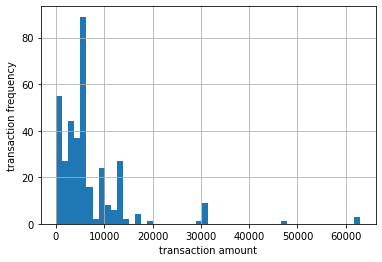

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax = transactions_control_1.revenue.hist(bins=50)
ax.set_xlabel('transaction amount')
ax.set_ylabel('transaction frequency')

Найдем, какой тип продукта больше покупают, какой приносит бОльший доход и какие средние размеры транзакций по категориям

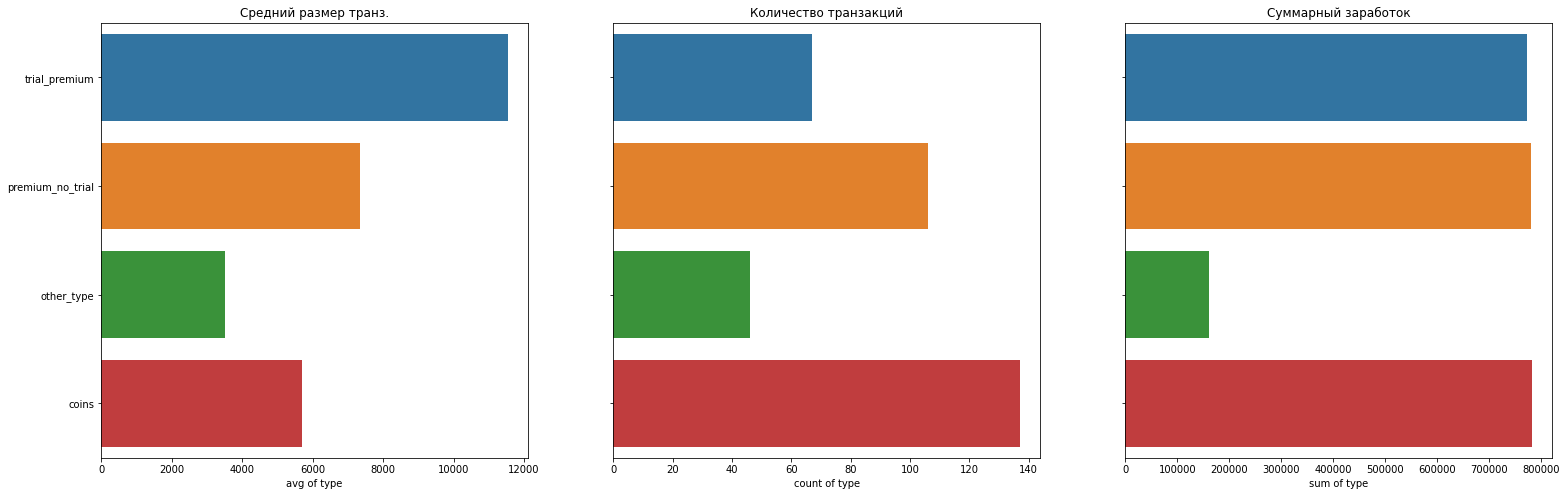

In [70]:
type_plot(transactions_control_1)

#### Вторая контрольная группа:

In [71]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [72]:
transactions_control_2.shape

(328, 8)

In [73]:
transactions_control_2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [74]:
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Проверим наличие полных дубликатов - при наличии - удаляем их

In [75]:
transactions_control_2.duplicated().sum()

5

In [76]:
transactions_control_2 = transactions_control_2.drop_duplicates()

Найдем временные рамки проведенных покупок и регистраций пользователей:

In [77]:
time_frame(transactions_control_2)

Рамки регистраций пользователей: c 2017-01-11
                                до 2017-10-31

Рамки проведения транзакций:     c 2017-01-11
                                до 2017-12-11



Найдем суммарный доход:

In [78]:
rev_t_c2 = transactions_control_2.revenue.sum()
print(f'Суммарный заработок во  2-й контрольной группе - {rev_t_c2} ')
print(f'Проверим, общий доход должен бы совпадать - {rev_u_c2} и {rev_t_c2} -> {rev_u_c2 == rev_t_c2}')

Суммарный заработок во  2-й контрольной группе - 1907997 
Проверим, общий доход должен бы совпадать - 1920438 и 1907997 -> False


Странно, общий доход в файлах users_control_2 и transactions_control_2 не совпадает....   
Интересно, разница в несколько процентов, уточним этот момент в процессе проверки сплитования, когда заодно будем проверять соответвие пользователей

Посмотрим на распределение транзакций пользователей

Text(0, 0.5, 'transaction frequency')

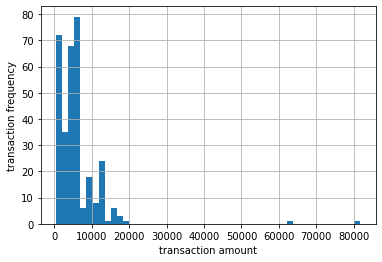

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax = transactions_control_2.revenue.hist(bins=50)
ax.set_xlabel('transaction amount')
ax.set_ylabel('transaction frequency')

Найдем, какой тип продукта больше покупают, какой приносит бОльший доход и какие средние размеры транзакций по категориям

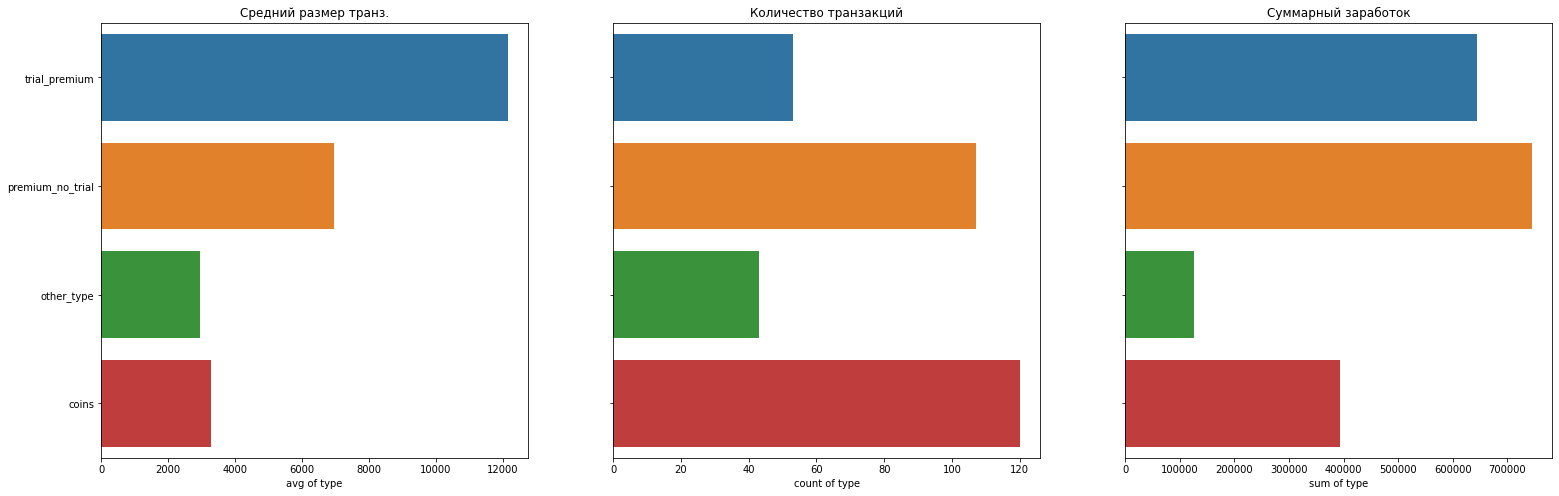

In [80]:
type_plot(transactions_control_2)

#### Тестовая группа:

In [81]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [82]:
transactions_test.shape

(273, 8)

In [83]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [84]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Проверим наличие полных дубликатов - при наличии - удаляем их

In [85]:
transactions_test.duplicated().sum()

7

In [86]:
transactions_test = transactions_test.drop_duplicates()

Найдем временные рамки проведенных покупок и регистраций пользователей:

In [87]:
time_frame(transactions_test)

Рамки регистраций пользователей: c 2017-01-11
                                до 2017-10-31

Рамки проведения транзакций:     c 2017-01-11
                                до 2017-12-11



Найдем суммарный заработок:

In [88]:
rev_t_t = transactions_test.revenue.sum()
print(f'Суммарный заработок в тестовой группе - {rev_t_t} ')
print(f'Проверим, общий доход должен бы совпадать - {rev_u_t} и {rev_t_t} -> {rev_u_t == rev_t_t}')

Суммарный заработок в тестовой группе - 2332226 
Проверим, общий доход должен бы совпадать - 2300818 и 2332226 -> False


Странно, общий доход в файлах users_test и transactions_test не совпадает....   
Интересно, разница в несколько процентов, уточним этот момент в процессе проверки сплитования, когда заодно будем проверять соответвие пользователей

Посмотрим на распределение транзакций пользователей

Text(0, 0.5, 'transaction frequency')

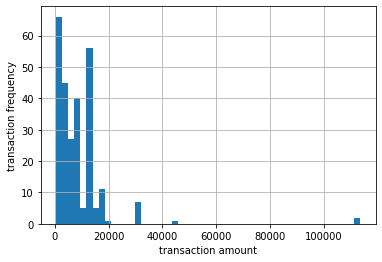

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax = transactions_test.revenue.hist(bins=50)
ax.set_xlabel('transaction amount')
ax.set_ylabel('transaction frequency')

Найдем, какой тип продукта больше покупают, какой приносит бОльший доход и какие средние размеры транзакций по категориям

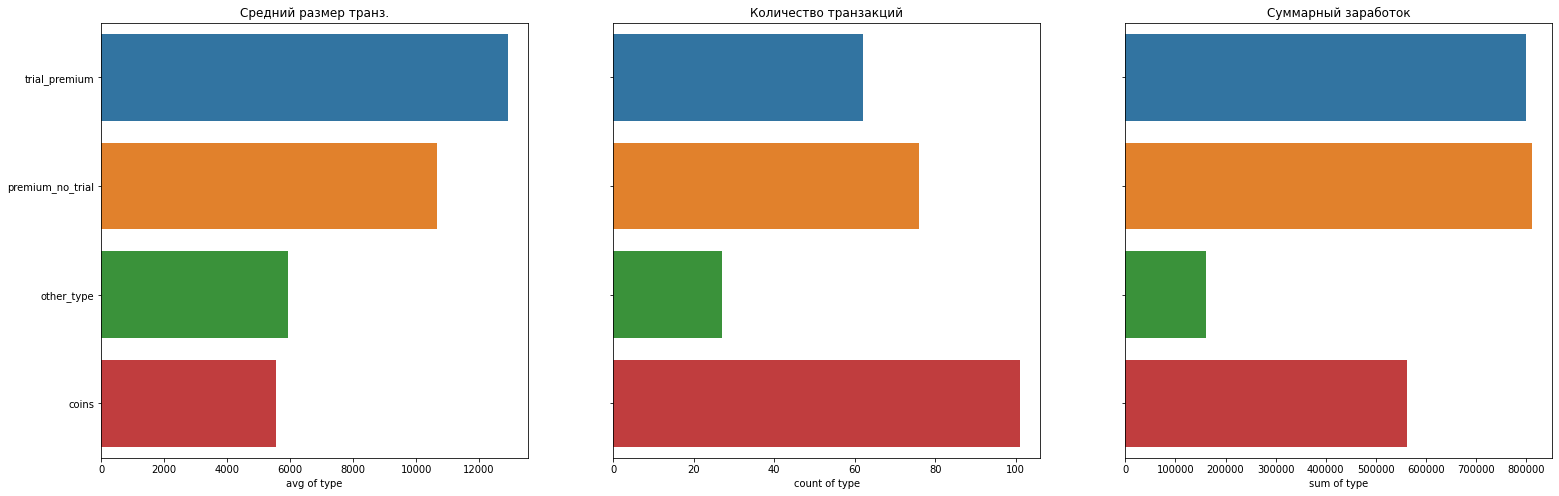

In [90]:
type_plot(transactions_test)

## 2. Сравнение групп пользователей и исправление недочетов
[Содержание](#Содержание)

Вспомним, что рамки проведения транзакций transactions_control_1 отличаются от двух других групп, найдем размер различий:

In [91]:
print('Для transactions_control_1')
time_frame(transactions_control_1)
print('Для transactions_control_2')
time_frame(transactions_control_2)
print('Для transactions_test')
time_frame(transactions_test)

Для transactions_control_1
Рамки регистраций пользователей: c 2015-01-19
                                до 2017-10-31

Рамки проведения транзакций:     c 2016-12-14
                                до 2017-12-11

Для transactions_control_2
Рамки регистраций пользователей: c 2017-01-11
                                до 2017-10-31

Рамки проведения транзакций:     c 2017-01-11
                                до 2017-12-11

Для transactions_test
Рамки регистраций пользователей: c 2017-01-11
                                до 2017-10-31

Рамки проведения транзакций:     c 2017-01-11
                                до 2017-12-11



In [92]:
transactions_control_1.joined_at.sort_values().head()

65    2015-01-19 11:49:00
224   2015-01-19 11:49:00
101   2015-01-19 11:49:00
342   2017-01-11 01:06:00
368   2017-01-11 01:06:00
Name: joined_at, dtype: datetime64[ns]

In [93]:
transactions_control_1.paid_at.sort_values().head()

224   2016-12-14 16:16:00
65    2016-12-14 17:30:00
101   2016-12-14 17:35:00
374   2017-01-11 02:56:00
124   2017-01-11 04:10:00
Name: paid_at, dtype: datetime64[ns]

In [94]:
transactions_control_1.query('joined_at == "2015-01-19 11:49:00"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type


In [95]:
users_control_1.query('uid == 960936960')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,extended_premium
510,960936960,30,4,99958,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1,1,26,2


Дедаем вывод, что в transactions_control_1 попали три лишние записи(отличаются и рамки регистрации пользователя, и рамки проведения транзакций) - удалим эти данные из users_control_1 и transactions_control_1

In [96]:
transactions_control_1 = transactions_control_1.drop(index=[65, 101, 224])
users_control_1 = users_control_1.drop(index=[510])

Теперь у нас для всех трех групп одинаковые рамки эксперимента

Найдем возможные пересечения пользователей из разных групп(проверим независимость выборок)

In [97]:
u_c1, t_c1 = set(users_control_1.uid.tolist()), set(transactions_control_1.uid.tolist())
u_c2, t_c2 = set(users_control_2.uid.tolist()), set(transactions_control_2.uid.tolist())
u_t,  t_t  = set(users_test.uid.tolist()),      set(transactions_test.uid.tolist())

print(u_c1 & u_c2, u_c2 & u_t, u_t & u_c1)
print(t_c1 & t_c2, t_c2 & t_t, t_t & t_c1)

set() set() set()
set() set() set()


Проверим соответвие платящих пользователей из users и пользователей из transactions

In [98]:
u_c1_p = set(users_control_1.query('total_revenue > 0').uid.tolist())
u_c2_p = set(users_control_2.query('total_revenue > 0').uid.tolist())
u_t_p  = set(users_test.query('total_revenue > 0').uid.tolist())

print(u_c1_p - t_c1, u_c2_p - t_c2, u_t_p - t_t)
print(t_c1 - u_c1_p, t_c2 - u_c2_p, t_t - u_t_p)

set() set() set()
{892355163} set() set()


Интересно, суммарный доход не сходится ни в одной из групп, а различные данные только в control_1     
Посмотрим на этого пользователя

In [99]:
users_control_1.query('uid == 892355163')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,extended_premium
3370,892355163,40,640,0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1,0,0,1


In [100]:
transactions_control_1.query('uid == 892355163')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
303,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68,super_popup,other_type


> __Смотря на вышеперечисленные недочеты - то, раз в транзакциях есть покупка, которой нет в пользователях + то, что скорее всего сначала сохраняются данные о транзакциях, а потом уже обновляются таблицы с пользователями, то будем считать верными данные в таблицах транзакций -> обновим и дополним таблицы пользователей, а именно столбцы с total_revenue, а также was_premium и is_premium(данные о покупках премиума могли не сохраниться, раз не было данных о покупке, и раз у нас данные о пользователях с момента их регистрации мы можем это сделать) -> получатся измененные столбцы:__
    
1. total_revenue - обновленный общий заработок      

    Следующие столбцы дополняются только для пользователей с sum(revenue) > 0          
    (именно дополняются, потому что у нас нет данных о покупках подписок за coins - если вдруг найдем, что подписка была куплена, то отметим, но если покупки не было, а подписка есть, то отменять не будем, потому что это может быть(скорее всего) покупка за монетки)
 

2. was_premium - был ли когда-то обычный премиум
3. is_premium - есть ли премиум на момент окончания обновления данных(аналогично покупке премиума в любую дату из промежутка [transactions_xxx_paid_at.max() - 30 days; transactions_xxx_paid_at.max()]

In [101]:
update_date(transactions_control_1, users_control_1)
update_date(transactions_control_2, users_control_2)
update_date(transactions_test, users_test)

Теперь имеем корректные данные и можем корректно оценить распределения переменных и сравнить их для оценки качетсва работы системы сплитования

## 3. Обновленные признаки и дополнительные графики для таблиц пользователей
[Содержание](#Содержание)

#### Для 1-й контрольной группы:

In [102]:
users_control_1.loc[:, ['was_premium', 'is_premium', 'total_revenue']].describe().T.round(2) 

,count,mean,std,min,25%,50%,75%,max
was_premium,4339.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0
is_premium,4339.0,0.04,0.21,0.0,0.0,0.0,0.0,1.0
total_revenue,4339.0,594.89,7988.84,0.0,0.0,0.0,0.0,486330.0


In [103]:
coin_rev_more_0(users_control_1)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 81.29
                          медиана = 11.0
Для total_revenue > 0 --> среднее(оно же ARPPU) = 13514.35
                          медиана(median  RPPU) = 9490.0


In [104]:
rev_u_c1 = users_control_1.total_revenue.sum()
print(f'Суммарный заработок в 1-й контрольной группе - {rev_u_c1} ')

Суммарный заработок в 1-й контрольной группе - 2581241 


Выведем сведения о продлении по всей первой контрольной группе:

In [105]:
extended_premium(users_control_1)

Продлевали премиум     - 191  пользователя или 4.4 %
Не продлевали премиум  - 244  пользователя или 5.62 %
Премиума не было и нет - 3904 пользователя или 89.97 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 10.03 %
Абсолютная CR в продление подписки 4.4 %


Добавим колонку с количеством дней, в которые пользователь заходил в прилложение и посмотрим на гистограммы распределения некоторых признаков

In [106]:
users_control_1['cnt_visit_days'] = users_control_1.visit_days.apply(lambda x: 0 if x=='0' else len(x.split(',')))

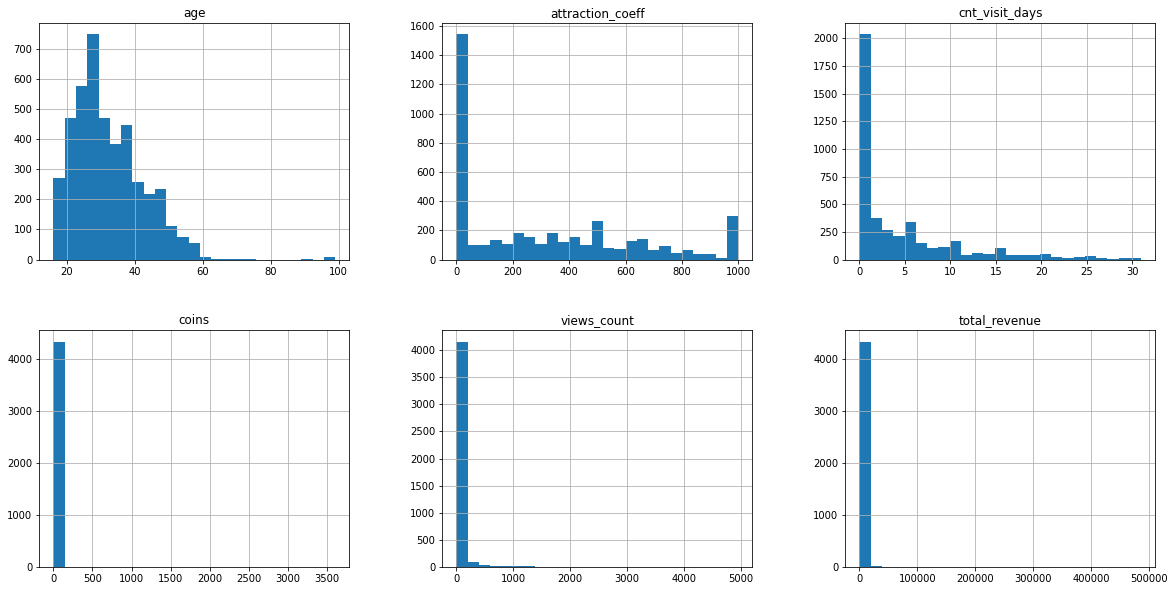

In [107]:
gist_var = ['age', 'attraction_coeff', 'cnt_visit_days', 'coins', 'views_count', 'total_revenue']
users_control_1[gist_var].hist(figsize=(20, 10), layout=(2, 3), bins=25);

Найдем топ стран по количеству пользователей(оставим те страны, где 100 и больше пользователей)

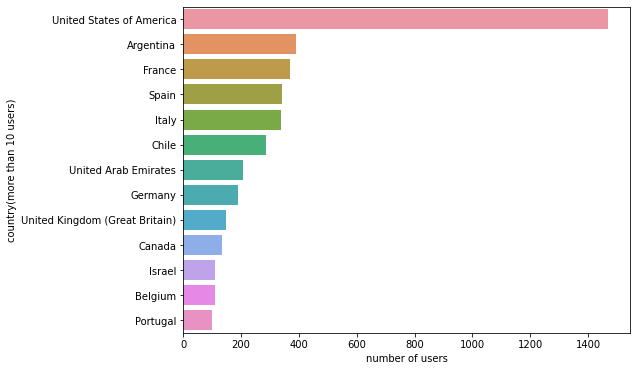

In [108]:
country_user_plot(users_control_1)

Построим таблицу с некоторыми отличающимися занчениями для каждой из вышеупомянутых стран:

In [109]:
country_table(users_control_1)

,country,cnt_users,was_premium_per,extended_2_per,avg_age,ARPU,ARPPU,median RPPU
0,United States of America,1471,12.10,4.42,30.70,485.17,12096.39,9139.0
1,Argentina,389,4.11,3.08,32.33,371.95,12057.50,10556.0
2,France,370,8.92,4.59,33.02,498.25,8379.68,6318.0
3,Spain,342,9.06,2.63,31.04,289.65,11006.67,11011.0
4,Italy,338,8.28,3.85,35.23,1874.85,37276.35,6539.0
5,Chile,287,4.88,3.14,31.66,339.95,9756.50,9945.0
6,United Arab Emirates,207,12.08,4.83,29.85,364.94,10791.86,10153.0
7,Germany,188,6.91,3.19,34.01,127.65,4799.60,4056.0
8,United Kingdom (Great Britain),146,13.70,7.53,31.34,1362.77,19896.50,11583.0
9,Canada,134,14.93,5.22,35.39,686.96,10228.11,9087.0


#### Для 2-й контрольной группы:

In [110]:
users_control_2.loc[:, ['was_premium', 'is_premium', 'total_revenue']].describe().T.round(2) 

,count,mean,std,min,25%,50%,75%,max
was_premium,4264.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0
is_premium,4264.0,0.04,0.21,0.0,0.0,0.0,0.0,1.0
total_revenue,4264.0,450.38,2859.24,0.0,0.0,0.0,0.0,81796.0


In [111]:
coin_rev_more_0(users_control_2)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 18.15
                          медиана = 10.0
Для total_revenue > 0 --> среднее(оно же ARPPU) = 10269.72
                          медиана(median  RPPU) = 7969.0


In [112]:
rev_u_c2 = users_control_2.total_revenue.sum()
print(f'Суммарный заработок в 1-й контрольной группе - {rev_u_c2} ')

Суммарный заработок в 1-й контрольной группе - 1920438 


Выведем сведения о продлении по всей первой контрольной группе:

In [113]:
extended_premium(users_control_2)

Продлевали премиум     - 191  пользователя или 4.48 %
Не продлевали премиум  - 220  пользователя или 5.16 %
Премиума не было и нет - 3853 пользователя или 90.36 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 9.64 %
Абсолютная CR в продление подписки 4.48 %


Добавим колонку с количеством дней, в которые пользователь заходил в прилложение и посмотрим на гистограммы распределения некоторых признаков

In [114]:
users_control_2['cnt_visit_days'] = users_control_2.visit_days.apply(lambda x: 0 if x=='0' else len(x.split(',')))

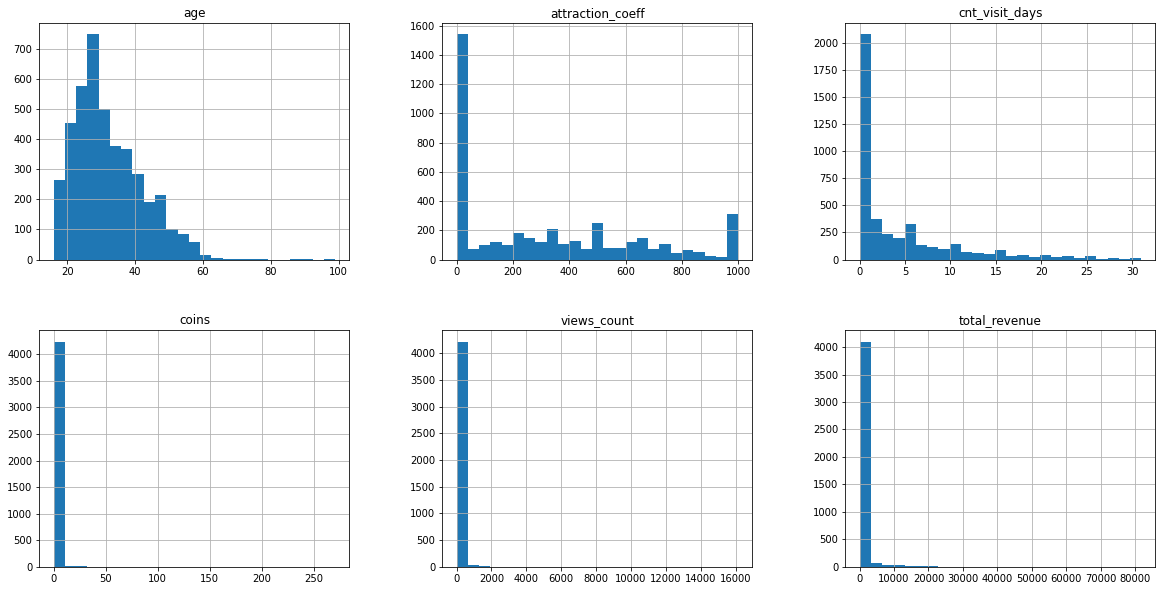

In [115]:
gist_var = ['age', 'attraction_coeff', 'cnt_visit_days', 'coins', 'views_count', 'total_revenue']
users_control_2[gist_var].hist(figsize=(20, 10), layout=(2, 3), bins=25);

Найдем топ стран по количеству пользователей(оставим те страны, где 100 и больше пользователей)

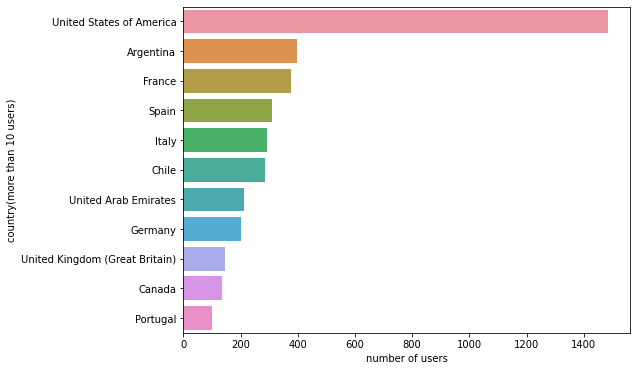

In [116]:
country_user_plot(users_control_2)

Построим таблицу с некоторыми отличающимися занчениями для каждой из вышеупомянутых стран:

In [117]:
country_table(users_control_2)

,country,cnt_users,was_premium_per,extended_2_per,avg_age,ARPU,ARPPU,median RPPU
0,United States of America,1486,12.18,4.78,30.51,393.14,9128.23,8950.5
1,Argentina,397,4.28,2.52,32.42,304.83,12101.70,10354.5
2,France,376,8.51,3.46,32.51,396.47,7845.84,6344.0
3,Spain,310,9.03,4.84,32.52,625.09,16148.17,6331.0
4,Italy,293,8.53,3.07,35.26,406.11,7436.81,6786.0
5,Chile,286,3.85,3.15,33.44,379.77,9874.09,9945.0
6,United Arab Emirates,211,8.06,3.79,28.69,555.18,23428.60,9516.0
7,Germany,202,8.42,3.47,34.79,353.51,14281.80,12727.0
8,United Kingdom (Great Britain),146,10.27,6.16,31.38,660.77,9647.30,6493.5
9,Canada,134,12.69,5.22,35.79,227.89,7634.25,7956.0


#### Для тестовой группы:

In [118]:
users_test.loc[:, ['was_premium', 'is_premium', 'total_revenue']].describe().T.round(2) 

,count,mean,std,min,25%,50%,75%,max
was_premium,4308.0,0.09,0.29,0.0,0.0,0.0,0.0,1.0
is_premium,4308.0,0.04,0.19,0.0,0.0,0.0,0.0,1.0
total_revenue,4308.0,534.08,4371.68,0.0,0.0,0.0,0.0,129870.0


In [119]:
coin_rev_more_0(users_test)

Cредние и медианные значения coins и total_revenue для соответ. ненулевых знач. пользователей
Для сoins > 0  ---------> среднее = 229.84
                          медиана = 9.0
Для total_revenue > 0 --> среднее(оно же ARPPU) = 15759.03
                          медиана(median  RPPU) = 12727.0


In [120]:
rev_u_t = users_test.total_revenue.sum()
print(f'Суммарный заработок в 1-й контрольной группе - {rev_u_t} ')

Суммарный заработок в 1-й контрольной группе - 2300818 


Выведем сведения о продлении по всей первой контрольной группе:

In [121]:
extended_premium(users_test)

Продлевали премиум     - 157  пользователя или 3.64 %
Не продлевали премиум  - 251  пользователя или 5.83 %
Премиума не было и нет - 3900 пользователя или 90.53 %

Тогда соответсвующие конверсии:
Абсолютная CR в подписку 9.47 %
Абсолютная CR в продление подписки 3.64 %


Добавим колонку с количеством дней, в которые пользователь заходил в прилложение и посмотрим на гистограммы распределения некоторых признаков

In [122]:
users_test['cnt_visit_days'] = users_test.visit_days.apply(lambda x: 0 if x=='0' else len(x.split(',')))

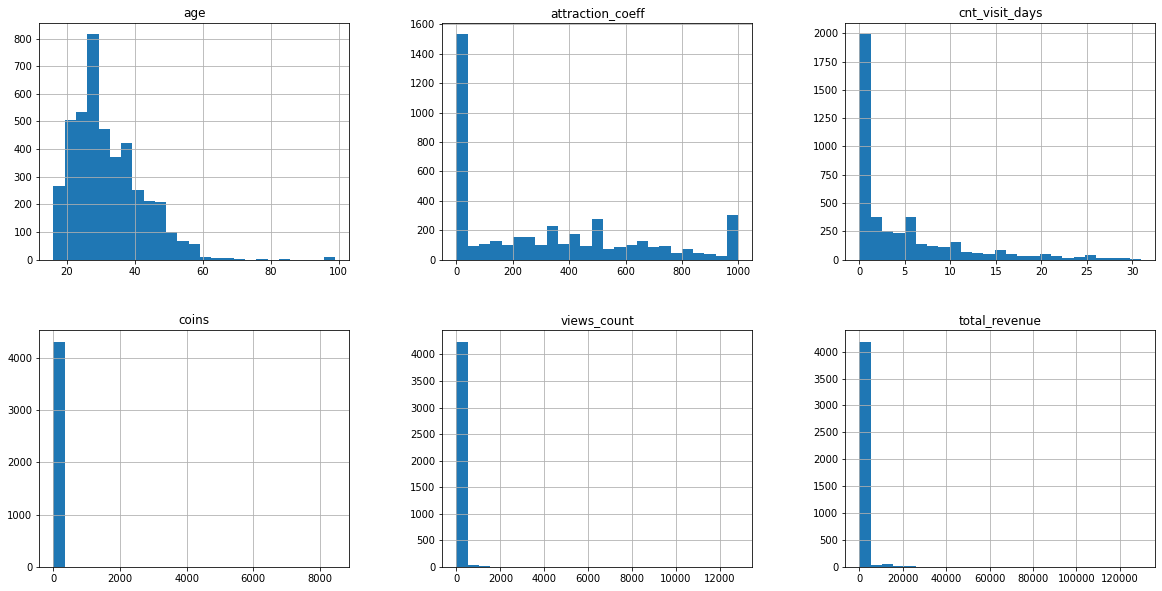

In [123]:
gist_var = ['age', 'attraction_coeff', 'cnt_visit_days', 'coins', 'views_count', 'total_revenue']
users_test[gist_var].hist(figsize=(20, 10), layout=(2, 3), bins=25);

Найдем топ стран по количеству пользователей(оставим те страны, где 100 и больше пользователей)

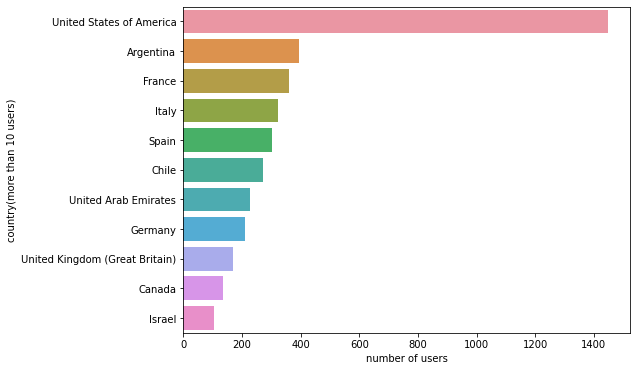

In [124]:
country_user_plot(users_test)

Построим таблицу с некоторыми отличающимися занчениями для каждой из вышеупомянутых стран:

In [125]:
country_table(users_test)

,country,cnt_users,was_premium_per,extended_2_per,avg_age,ARPU,ARPPU,median RPPU
0,United States of America,1450,11.79,3.59,30.24,497.82,13881.50,12662.0
1,Argentina,396,4.04,1.77,33.12,474.80,26859.86,12597.0
2,France,359,6.96,4.46,33.52,706.45,19509.00,16536.0
3,Italy,323,6.19,2.48,34.31,351.16,12602.78,12597.0
4,Spain,301,10.63,4.65,30.81,948.27,19028.53,12727.0
5,Chile,272,2.94,2.57,32.68,257.13,17485.00,16620.5
6,United Arab Emirates,226,11.50,6.64,28.63,945.95,23753.89,13247.0
7,Germany,209,12.92,3.83,34.56,459.79,13728.00,12597.0
8,United Kingdom (Great Britain),169,12.43,4.14,29.61,457.85,9672.00,10419.5
9,Canada,137,15.33,5.11,36.36,463.26,10577.67,11206.0


## 4. Проверка качества сплитования
[Содержание](#Содержание)

Для удобства объединим данные в один датафрэйм

In [126]:
users_control_1['group'], users_control_2['group'], users_test['group']  = 'control_1', 'control_2', 'test'
data_users = pd.concat([users_control_1, users_control_2, users_test])

transactions_control_1['group'], transactions_control_2['group'] = 'control_1', 'control_2'
transactions_test['group'] = 'test'
data_transactions = pd.concat([transactions_control_1, transactions_control_2, transactions_test])

Сведем распределения пропорций различных признаков по 3м выборкам в одну таблицу:     
Данные признаки не должны отличаться во всех трех подгруппах(грубо говоря они зависят преимущественно от деления трафика = от системы сплитования count_users, avg_age, avg_attr_c, per_users_from_usa(кол-во юзеров из америки как из основного пользователя), avg_gender, avg_age_filter_start, avg_age_filter_end     
          
При помощи однофакторного дисперсионного анализа(с поправкой Тьюки на множественные сравнения) докажем, что между выборками нет различий в этих критериях

\begin{equation*}
\begin{aligned} 
& H_0: \text{ни одно из выборочных средних не отличается от другого (нет различий)} \\
& H_a: \text{хотя бы одно выборочное среднее отличается от других (есть различия как минимум между двумя группами)}  
\end{aligned}
\end{equation*}

Для этого требуется соблюдать требование гомогенности дисперсий - для его проверки воспользумся критерием Левена

\begin{equation*}
\begin{aligned} 
& H_0: \text{Дисперсии выборок не отличаются} \\
& H_a: \text{Между дисперсиями есть различие}  
\end{aligned}
\end{equation*}

In [127]:
signs_of_groups(data_users)

,group,uid,avg_age,avg_atr_coeff,avg_gender,avg_age_f_start,avg_age_f_end,cnt_from_usa
0,control_1,4339,32.1,312.12,0.96,26.79,38.55,0.34
1,control_2,4264,32.05,317.96,0.95,26.95,38.91,0.35
2,test,4308,31.89,316.41,0.95,26.7,38.25,0.34
3,equal_var(leven),-->,0.67,0.46,0.51,0.49,0.32,0.47
4,"p-tukey[1-2, 1-t, 2-t]",-->,"[0.9, 0.61, 0.74]","[0.66, 0.79, 0.9]","[0.66, 0.51, 0.9]","[0.69, 0.88, 0.43]","[0.53, 0.63, 0.12]","[0.61, 0.9, 0.48]"


При заданном уровне значимости alpha=0.05 гипотезы равенстве средних вышеперечисленных велечин принимаются.    

> __Значит в наших трех исправленных выборках соблюдаются временные рамки проведения эксперимента, выполняются условия независимости(по пользователям) и репрезентативности(в данном случае понимаем как соответвие начальных данных друг другу ака равенство срених велечин из таблицы выше). Поэтому считаю, что скорректированные данные(удаление пользователей, выходящих за временные рамки + пересчет дохода и наличия подписки в таблицах users) можно использовать для проведения A/A/B тестов__

## 5. Гипотезы и тесты

### 5.1 Гипотеза о равенстве medianRPPU
[Содержание](#Содержание)

Для начала взглянем на распределения total_revenue (для пользователей с total_revenue > 0)

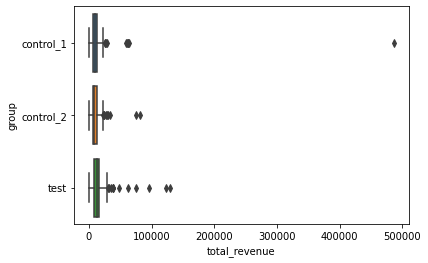

In [128]:
sns.boxplot(data=data_users.query('0 < total_revenue'), x='total_revenue', y='group')

Посмотрим без значительных выбросов:

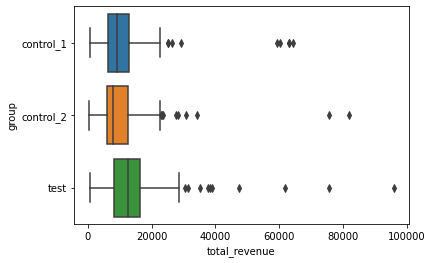

In [129]:
sns.boxplot(data=data_users.query('0 < total_revenue < 100000'), x='total_revenue', y='group')

Из-за больших выбросов(чтобы их не отсекать для возможности использовать другие методы) воспользуемся непараметрическим аналогом ANOVA - тестом Краскала-Уоллеса :


\begin{equation*}
\begin{aligned} 
& H_0: \text{Во всех группах одинаковое значение medianRPPU}   \\
& H_a: \text{В тестовой группе medianRPPU отличается}  
\end{aligned}
\end{equation*}


In [130]:
pg.kruskal(data=data_users.query('total_revenue > 0'), dv='total_revenue', between='group')

,Source,ddof1,H,p-unc
Kruskal,group,2,21.287528,0.000024


При заданном уровне значимости alpha=0.05 гипотеза о равенстве medianRPPU отклоняется. Проверим аналогично попарно группы  при помощи U-критерия Манна-Уитни и поправки Холма на множественные сравнения:

\begin{equation*}
\begin{aligned} 
& H_0: \text{Распределения в двух группах равны}   \\
& H_a: \text{Распределение, лежащее в основе test, стохастически больше, чем распределение лежащее в основе control} \\
&            \text{(упрощая для нас - значит и его медиана и medianRPPU больше)} 
\end{aligned}
\end{equation*}


In [131]:
mwu_1 = data_users.query('total_revenue > 0 & group == "control_1"').total_revenue
mwu_2 = data_users.query('total_revenue > 0 & group == "control_2"').total_revenue
mwu_t = data_users.query('total_revenue > 0 & group == "test"').total_revenue

In [132]:
pg.mwu(mwu_t.tolist(), mwu_1.tolist(), alternative='greater')

,U-val,alternative,p-val,RBC,CLES
MWU,17135.5,greater,0.000157,-0.228968,0.614484


In [133]:
pg.mwu(mwu_t.tolist(), mwu_2.tolist(), alternative='greater')

,U-val,alternative,p-val,RBC,CLES
MWU,17455.5,greater,0.000006,-0.278698,0.639349


Воспользуемся поправкой Холма на множественное сравнение

In [137]:
print(multipletests([0.000157, 0.000006], alpha=0.05, method='holm')[1])

[1.57e-04 1.20e-05]


> __При заданном уровне значимости alpha=0.05 принимаются альтернативные гипотезы о том, что medianRPPU в тестовой группе больше, чем в 1-контрольной и больше, чем во  2-контрольной.__

Чтобы узнать, насколько в среднем значение medianRPPU в тестовой группе превышает контрольные группы, воспользуемся бутстрэпом. 

> __Обладая только данными по имеющейся выборке, у нас есть возможность оценить любой её параметр, построив эмпирическое распределение - строим распределение медиан для теста и контролей, производим вычитание матриц, в получившемся распределении находим доверительный интервал - это и будет искомое значение(также можно рассчиать p-val и подтвердить наши вычисления)__

In [138]:
boot_t_1 = get_pvalue(get_bootstrap(mwu_t, mwu_1, boot_it = 100000))
boot_t_2 = get_pvalue(get_bootstrap(mwu_t, mwu_2, boot_it = 100000))

In [139]:
p_cor_1, p_cor_2 = multipletests([boot_t_1[0], boot_t_2[0]], alpha=0.05, method='holm')[1]

print(round(p_cor_1, 4), boot_t_1[1].round(2).values.tolist())
print(round(p_cor_2, 4), boot_t_2[1].round(2).values.tolist())

0.0001 [[936.0], [3952.0]]
0.0 [[1664.0], [5031.0]]


> **Таким образом, гипотеза о равенстве medianRPPU по всем продуктам на 5% уровне значимости отвергается:**
>- **В тестовой группе medianRPPU выше чем в 1-й контрольной группе в среднем на $[936; 3952]$ ден. единиц;**
>- **В тестовой группе medianRPPU выше чем во 2-й контрольной группе в среднем на $[1664; 5031]$ ден. единиц.**

### 5.2 Гипотеза о равенстве дохода с оформления  подписок(не пробных)

Для начала взглянем на распределения revenue типа покупки premium_no_trial

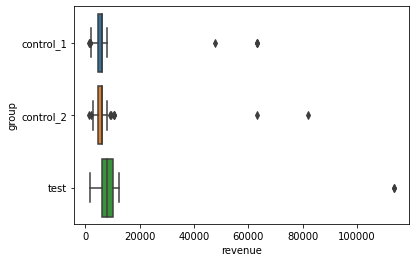

In [149]:
sns.boxplot(data=data_transactions.query('product_type == "premium_no_trial"'), x='revenue', y='group')

Посмотрим без значительных выбросов:

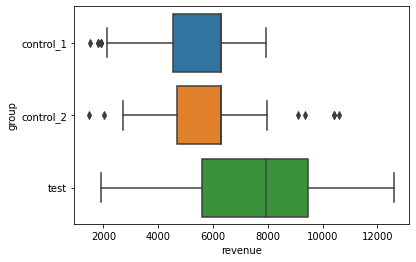

In [150]:
sns.boxplot(data=data_transactions.query('product_type == "premium_no_trial" & revenue < 40000'), x='revenue', y='group')

Для проверки гомогенности дисперсий воспользумся критерием Левена

\begin{equation*}
\begin{aligned} 
& H_0: \text{Дисперсии выборок не отличаются} \\
& H_a: \text{Между дисперсиями есть различие}  
\end{aligned}
\end{equation*}

In [151]:
pg.homoscedasticity(data=data_transactions.query('product_type == "premium_no_trial"'), dv="revenue", group="group")

,W,pval,equal_var
levene,1.515722,0.221409,True


Из-за наличия выбросов воспользуемся непараметрическим аналогом ANOVA - тестом Краскала-Уоллеса :


\begin{equation*}
\begin{aligned} 
& H_0: \text{Во всех группах одинаковое значение медианного дохода с оформления подписок }   \\
& H_a: \text{В тестовой группе медианный доход с оформления подписок отличается}  
\end{aligned}
\end{equation*}


In [152]:
pg.kruskal(data=data_transactions.query('product_type == "premium_no_trial"'), dv='revenue', between='group')

,Source,ddof1,H,p-unc
Kruskal,group,2,33.443358,5.468486e-08


При заданном уровне значимости alpha=0.05 гипотеза о равенстве медианного дохода с оформления подписок отклоняется. Поищем различия в группах  при помощи U-критерия Манна-Уитни и поправки Холма:

\begin{equation*}
\begin{aligned} 
& H_0: \text{Распределения в двух группах равны}   \\
& H_a: \text{Распределение, лежащее в основе test, стохастически больше, чем распределение лежащее в основе control} \\
&            \text{(упрощая для нас - значит и его медиана больше)} 
\end{aligned}
\end{equation*}

In [153]:
mwu_1 = data_transactions.query('product_type == "premium_no_trial" & group == "control_1"').revenue
mwu_2 = data_transactions.query('product_type == "premium_no_trial" & group == "control_2"').revenue
mwu_t = data_transactions.query('product_type == "premium_no_trial" & group == "test"').revenue

In [154]:
pg.mwu(mwu_t.tolist(), mwu_1.tolist(), alternative='greater')

,U-val,alternative,p-val,RBC,CLES
MWU,5866.0,greater,6.003202e-08,-0.456306,0.728153


In [155]:
pg.mwu(mwu_t.tolist(), mwu_2.tolist(), alternative='greater')

,U-val,alternative,p-val,RBC,CLES
MWU,5771.0,greater,5.687226e-07,-0.419331,0.709666


Воспользуемся поправкой Холма на множественное сравнение

In [156]:
print(multipletests([6.003202e-08, 5.687226e-07], alpha=0.05, method='holm')[1])

[1.2006404e-07 5.6872260e-07]


> __При заданном уровне значимости alpha=0.05 принимаются альтернативные гипотезы о том,  что в тестовой группе медианный доход с оформления подписок выше, чем в 1-контрольной и выше, чем во 2-контрольной.__

Чтобы узнать, насколько в среднем медианный доход с оформления подписок в тестовой группе превышает контрольные группы, воспользуемся бутстрэпом. 

In [157]:
mwu_t__mwu_1 = get_pvalue(get_bootstrap(mwu_t, mwu_1, boot_it = 100000))
mwu_t__mwu_2 = get_pvalue(get_bootstrap(mwu_t, mwu_2, boot_it = 100000))

In [173]:
p_cor_1, p_cor_2 = multipletests([mwu_t__mwu_1[0], mwu_t__mwu_2[0]], alpha=0.05, method='holm')[1]

print(round(p_cor_1, 4), mwu_t__mwu_1[1].round(2).values.tolist())
print(round(p_cor_2, 4), mwu_t__mwu_2[1].round(2).values.tolist())

0.0 [[1625.0], [3048.5]]
0.0 [[1534.0], [2925.0]]


> **Таким образом, гипотеза о равенстве дохода с оформления подписок на 5% уровне значимости отвергается:**
>- **В тестовой группе медианный доход с оформления подписок выше чем в 1-й контрольной группе в среднем на $[1625; 3048]$ ден. единиц;**
>- **В тестовой группе медианный доход с оформления подписок выше чем во 2-й контрольной группе в среднем на $[1534; 2925]$ ден. единиц.**

### 5.3 Гипотеза о равенстве CR в подписку

Взглянем на распределения СR (аналогично отношению was_premium ко всем пользователям)

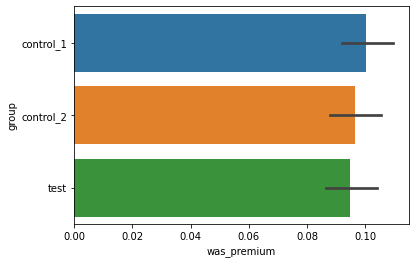

In [159]:
sns.barplot(data=data_users, x='was_premium', y='group')

Воспользуемся бутстрэпом, чтобы проверить 

\begin{equation*}
\begin{aligned} 
& H_0: \text{В двух группах одинаковый CR в подписку}   \\
& H_a: \text{В одной из 2х групп CR в подписку отличается}  
\end{aligned}
\end{equation*}


In [160]:
cr_1 = data_users.query('group == "control_1"').was_premium
cr_2 = data_users.query('group == "control_2"').was_premium
cr_t = data_users.query('group == "test"').was_premium

In [162]:
cr_1__cr_2 = get_pvalue(get_bootstrap(cr_1, cr_2, statistic = np.mean, boot_it = 100000))
cr_1__cr_t = get_pvalue(get_bootstrap(cr_1, cr_t, statistic = np.mean, boot_it = 100000))
cr_2__cr_t = get_pvalue(get_bootstrap(cr_2, cr_t, statistic = np.mean, boot_it = 100000))

In [174]:
p_cor_1, p_cor_2, p_cor_3 = multipletests([cr_1__cr_2[0], cr_1__cr_t[0], cr_2__cr_t[0]], alpha=0.05, method='holm')[1]

print(round(p_cor_1, 4))
print(round(p_cor_2, 4))
print(round(p_cor_3, 4))

0.575
0.575
0.575


> **Таким образом, нулевые гипотезы о равенстве CR в подписку на 5% уровне значимости для пар групп control_1 и control_2, control_1 и test, control_2 и test принимаются - различий не обнаружено**

### 5.4 Гипотеза о равенстве относительной CR из подписки в продление подписки
[Содержание](#Содержание)

Взглянем на распределения относительной CR из подписки в продление подписки(аналогично отношению extended_2 к was_premium)

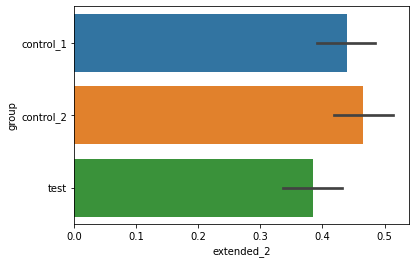

In [164]:
sns.barplot(data=data_users.query('was_premium == 1'), x='extended_2', y='group')

Воспользуемся бутстрэпом, чтобы проверить 

\begin{equation*}
\begin{aligned} 
& H_0: \text{В В двух группах одинаковое значение относительной CR из подписки в продление подписки}   \\
& H_a: \text{В одной из 2х относительный CR из подписки в продление подписки отличается}  
\end{aligned}
\end{equation*}


In [165]:
crr_1 = data_users.query('was_premium == 1 & group == "control_1"').extended_2
crr_2 = data_users.query('was_premium == 1 & group == "control_2"').extended_2
crr_t = data_users.query('was_premium == 1 & group == "test"').extended_2

In [167]:
crr_1__crr_2 = get_pvalue(get_bootstrap(crr_1, crr_2, statistic = np.mean, boot_it = 100000))
crr_1__crr_t = get_pvalue(get_bootstrap(crr_1, crr_t, statistic = np.mean, boot_it = 100000))
crr_2__crr_t = get_pvalue(get_bootstrap(crr_2, crr_t, statistic = np.mean, boot_it = 100000))

In [171]:
p_cor_1, p_cor_2, p_cor_3 = multipletests([crr_1__crr_2[0],crr_1__crr_t[0],crr_2__crr_t[0]], alpha=0.05, method='holm')[1]

print(round(p_cor_1, 4), crr_1__crr_2[1].round(4).values.tolist())
print(round(p_cor_2, 4), crr_1__crr_t[1].round(4).values.tolist())
print(round(p_cor_3, 4), crr_2__crr_t[1].round(4).values.tolist())

0.2231 [[-0.092], [0.0414]]
0.1024 [[-0.0115], [0.1195]]
0.0311 [[0.0122], [0.1484]]


> **Таким образом:**
>- **Гипотеза о равенстве относительной CR из подписки в продление подписки для пар групп control_1 и control_2, control_1 и test на 5% уровне значимости принимается - значимых различий не обнаружено:**
>- **Гипотеза о равенстве относительной CR из подписки в продление подписки для групп test и сontrol_1 на 5% уровне значимости отвергается - обнаружены значимые различия - относительный CR в *тестовой группе ниже* в среднем на на $[1.12; 14.84]$ процентных пункта**

### 5.5 Гипотеза о равенстве medianRPPU у пользователей из одних и тех же стран
[Содержание](#Содержание)

Для начала найдем страны, которые встречаются во всех трех группах:

In [175]:
c_1 = set(data_users.query('total_revenue > 0 & group == "control_1"').country.tolist())
c_2 = set(data_users.query('total_revenue > 0 & group == "control_2"').country.tolist())
t   = set(data_users.query('total_revenue > 0 & group == "test"').country.tolist())

need_c = list(c_1 & c_2 & t)
need_c

['Germany',
 'France',
 'Switzerland',
 'Chile',
 'Spain',
 'Australia',
 'Israel',
 'Belgium',
 'United Kingdom (Great Britain)',
 'United Arab Emirates',
 'United States of America',
 'Turkey',
 'Canada',
 'Italy',
 'Argentina']

In [176]:
ren_c = {'United States of America':'USA', 'United Kingdom (Great Britain)':'UK', 'United Arab Emirates':'UAE'}
data_country = data_users.query('0 < total_revenue & country in @need_c')
data_country.country = data_country.country.apply(lambda x: ren_c[x] if x in list(ren_c.keys()) else x)

Посмтрим на распределение для этих стран для total_revenue > 0 (без одного выброса в Italy == 486330) в этих странах:

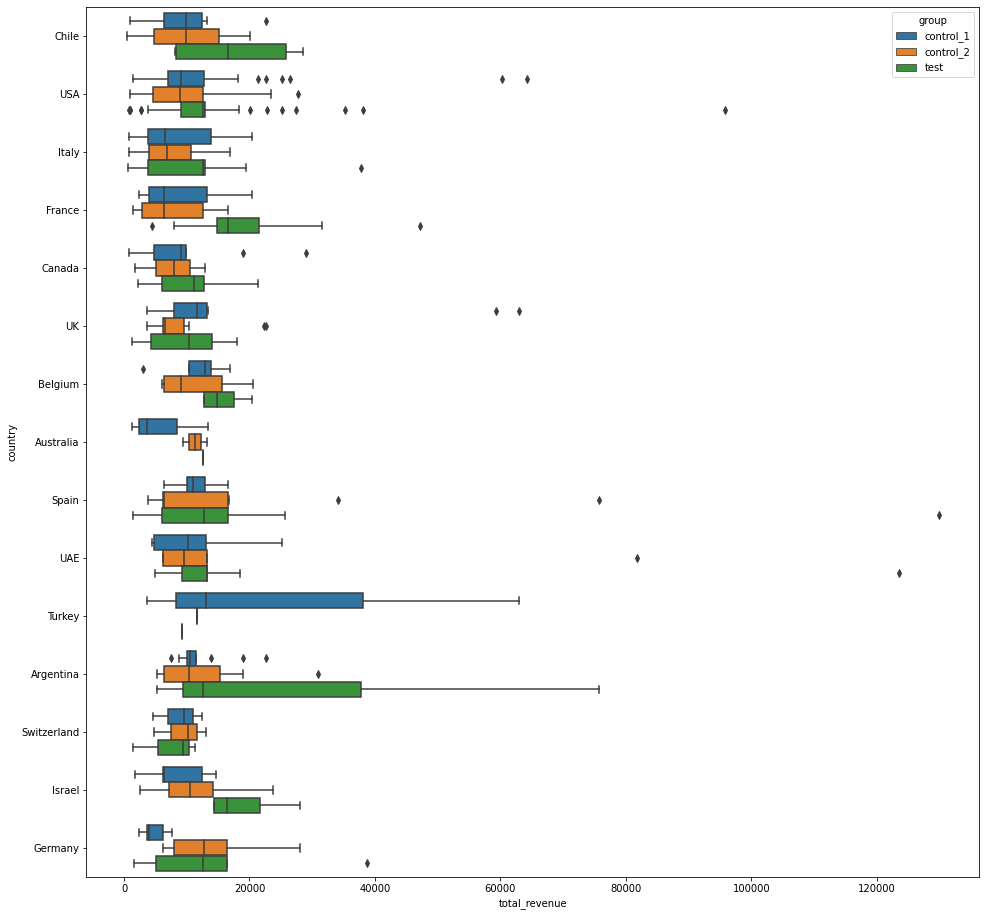

In [177]:
plt.figure(figsize=(16, 16))
sns.boxplot(data=data_country.query('total_revenue < 400000'),
            x='total_revenue', y='country', hue='group')

Так как при разбивке одновременно по странам и группам могут остаться очень маленькие выборки, оставим страны, где в каждой из 3 групп будет не менее 3х наблюдений  

In [178]:
data_country.groupby(['group', 'country'], as_index=False).agg({'uid':'count'}).sort_values('uid').head(10)

,group,country,uid
26,control_2,Turkey,1
31,test,Australia,1
41,test,Turkey,1
16,control_2,Australia,2
1,control_1,Australia,3
25,control_2,Switzerland,3
40,test,Switzerland,3
11,control_1,Turkey,3
10,control_1,Switzerland,3
34,test,Chile,4


In [179]:
data_country = data_country.query('country not in ["Turkey", "Australia"]')

Теперь при помощи бутрэпа проверим(не забываем про поправки на множественные сравнения)

\begin{equation*}
\begin{aligned} 
& H_0: \text{У пользователей из одних и тех же стран medianRPPU в тестовой и контрольной группах равны}   \\
& H_a: \text{У пользователей из одних и тех же стран medianRPPU в тестовой и контрольной отличаются} \\
&            \text{и заодно выведем доверительные интервалы разницы этих различий} 
\end{aligned}
\end{equation*}

Выведем в таблице для укаждой страны размеры групп, p-val и доверительный интервал для сравнения тестовой группы с 1-м контролем и со вторым контролем 

In [182]:
con_t = do_boot_median(data_country, col='country', boot_it = 100000)

In [183]:
con_t

,country,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
0,Argentina,"[12, 10, 7]","[10556.0, 10354.5, 12597.0]",0.5638,"[[-4270.5], [45103.5]]",0.5638,"[[-4407.0], [44791.5]]"
1,Belgium,"[4, 10, 4]","[12837.5, 9080.5, 14755.0]",0.1448,"[[-2112.5], [11680.5]]",0.0278,"[[-156.0], [9672.0]]"
2,Canada,"[9, 4, 6]","[9087.0, 7956.0, 11206.0]",0.4598,"[[-6864.0], [9048.0]]",0.4598,"[[-4062.5], [10036.0]]"
3,Chile,"[10, 11, 4]","[9945.0, 9945.0, 16620.5]",0.1189,"[[-1755.0], [18518.5]]",0.1189,"[[-1781.0], [18590.0]]"
4,France,"[22, 19, 13]","[6318.0, 6344.0, 16536.0]",0.0000,"[[4017.0], [13851.6625]]",0.0002,"[[3887.0], [14833.0]]"
5,Germany,"[5, 5, 7]","[4056.0, 12727.0, 12597.0]",0.1786,"[[-1443.0], [14053.0]]",0.3881,"[[-11739.0], [10088.0]]"
6,Israel,"[14, 6, 5]","[6298.5, 10588.5, 16380.0]",0.0000,"[[7143.5], [14534.0]]",0.0272,"[[-409.5], [15353.0]]"
7,Italy,"[17, 16, 9]","[6539.0, 6786.0, 12597.0]",0.3833,"[[-5668.0], [8645.0]]",0.2370,"[[-1690.0], [9295.0]]"
8,Spain,"[9, 12, 15]","[11011.0, 6331.0, 12727.0]",0.7254,"[[-4719.0], [6292.0]]",0.7254,"[[-4836.0], [8723.0]]"
9,Switzerland,"[3, 3, 3]","[9490.0, 10192.0, 9451.0]",0.6499,"[[-10894.0], [6617.0]]",0.6499,"[[-11596.0], [6500.0]]"


Найдем значения p-val < 0.05

In [184]:
con_t.loc[(con_t['p-val [t, c1]'] < 0.05) | (con_t['p-val [t, c2]'] < 0.05)]

,country,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
1,Belgium,"[4, 10, 4]","[12837.5, 9080.5, 14755.0]",0.1448,"[[-2112.5], [11680.5]]",0.0278,"[[-156.0], [9672.0]]"
4,France,"[22, 19, 13]","[6318.0, 6344.0, 16536.0]",0.0000,"[[4017.0], [13851.6625]]",0.0002,"[[3887.0], [14833.0]]"
6,Israel,"[14, 6, 5]","[6298.5, 10588.5, 16380.0]",0.0000,"[[7143.5], [14534.0]]",0.0272,"[[-409.5], [15353.0]]"
12,USA,"[59, 64, 52]","[9139.0, 8950.5, 12662.0]",0.1464,"[[-130.0], [3640.0]]",0.0032,"[[578.5], [5310.5]]"


> **Делаем выводы для 5% уровне значимости:**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается и с 1-й и со 2-й контрольной группой в следующих странах: значения больше во `France` - соответветсвенно в среднем на $[4017; 13852]$ и $[3887; 14833]$ ден. ед. и больше в `Israel` - соответвенно в среднем на $[7144; 14534]$ и $[-410; 15353]$	ден. ед.;**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается только со 2-й контрольной группой в следующих странах: значения больше в `Belgium` - в среднем на $[-156; 9672]$ ден. ед. и больше в `USA` - среднем на $[579;  5311]$ ден. ед.;**

### 5.6 Гипотеза о равенстве medianRPPU у пользователей одних и тех же возрастов и полов
[Содержание](#Содержание)

Выделим группы пользователей:

In [185]:
data_age = data_users.query('total_revenue > 0')
data_age['age_group'] = pd.cut(data_age.age, [0, 19, 25, 30, 35, 40, 50, 100],
                                labels=['16-19', '20-25', '26-30', '31-35', '36-40', '41-50', '51-99'])
data_age = data_age.astype({'age_group': 'str', 'gender':'str'})
data_age['age_gender'] = data_age.age_group + '(' + data_age.gender + ')'
data_age = data_age.sort_values('age_gender')

Посмтрим на распределение для этих групп для total_revenue > 0 (без одного выброса в Italy == 486330)

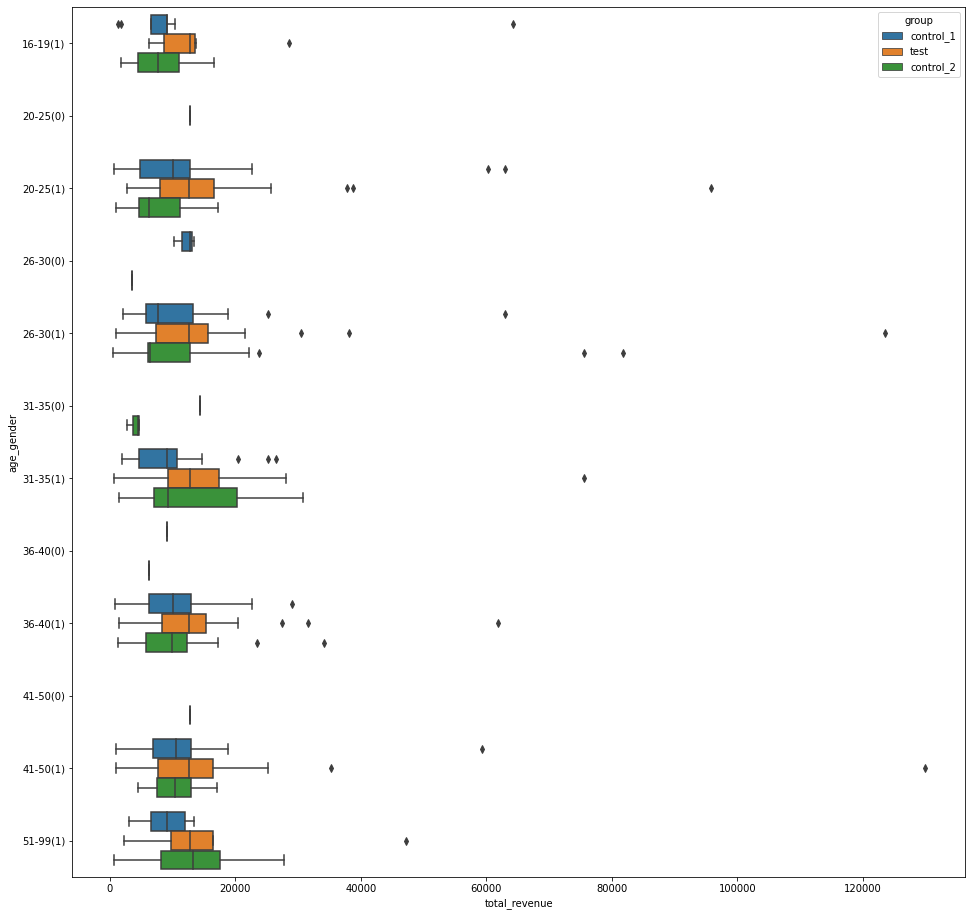

In [186]:
plt.figure(figsize=(16, 16))
sns.boxplot(data=data_age.query('total_revenue < 400000'),
            x='total_revenue', y='age_gender', hue='group')

Так как при разбивке одновременно возрасту, полу и варианту группы могут остаться очень маленькие выборки, оставим те подгруппы, где в каждой из 3 групп будет не менее 3х наблюдений

In [187]:
data_age.groupby(['group', 'age_gender'], as_index=False).agg({'uid':'count'}).sort_values('uid').head(10)

,group,age_gender,uid
24,test,31-35(0),1
21,test,20-25(0),1
5,control_1,36-40(0),1
17,control_2,41-50(0),1
11,control_2,26-30(0),1
15,control_2,36-40(0),2
2,control_1,26-30(0),3
13,control_2,31-35(0),3
20,test,16-19(1),7
19,control_2,51-99(1),7


Жалко, пола 0 слишком маленькое количество, и остался только gender = 1

In [188]:
data_age = data_age.query('age_gender not in ["20-25(0)", "26-30(0)", "31-35(0)", "36-40(0)","41-50(0)"]')

Теперь при помощи бутрэпа проверим(не забываем про поправки на множественные сравнения)

\begin{equation*}
\begin{aligned} 
& H_0: \text{У пользователей из одних и тех же возрастных групп medianRPPU в тестовой и контрольной группах равны}   \\
& H_a: \text{У пользователей из одних и тех же возрастных групп medianRPPU в тестовой и контрольной отличаются} \\
&            \text{и заодно выведем доверительные интервалы разницы этих различий} 
\end{aligned}
\end{equation*}

Выведем в таблице для каждой возрастной группы ее размер, p-val и доверительный интервал для сравнения тестовой группы с 1-м контролем и со вторым контролем 

In [189]:
age_t = do_boot_median(data_age, col='age_gender', boot_it = 100000)

In [190]:
age_t

,age_gender,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
0,16-19(1),"[9, 12, 7]","[9087.0, 7696.0, 12727.0]",0.1265,"[[-1300.0], [10985.0]]",0.0840,"[[-19.5], [9080.5]]"
1,20-25(1),"[53, 43, 29]","[10075.0, 6292.0, 12597.0]",0.0367,"[[-208.0], [5837.0]]",0.0026,"[[1872.0], [7995.0]]"
2,26-30(1),"[47, 49, 24]","[7722.0, 6461.0, 12597.0]",0.1085,"[[-923.0], [6305.0]]",0.1085,"[[-676.0], [6396.0]]"
3,31-35(1),"[25, 20, 33]","[9087.0, 9301.5, 12727.0]",0.0243,"[[52.0], [7995.0]]",0.2973,"[[-3991.0], [5473.0]]"
4,36-40(1),"[17, 20, 23]","[10075.0, 9867.0, 12597.0]",0.2977,"[[-3146.0], [6851.0]]",0.2977,"[[-2249.0], [6955.0]]"
5,41-50(1),"[26, 29, 19]","[10536.5, 10413.0, 12597.0]",0.5342,"[[-2951.0], [5817.5]]",0.5342,"[[-3029.0], [4823.0]]"
6,51-99(1),"[10, 7, 9]","[9113.0, 13208.0, 12727.0]",0.2109,"[[-1878.5], [8443.5]]",0.4643,"[[-10478.0], [8853.0]]"


In [191]:
age_t.loc[(age_t['p-val [t, c1]'] < 0.05) | (age_t['p-val [t, c2]'] < 0.05)]

,age_gender,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
1,20-25(1),"[53, 43, 29]","[10075.0, 6292.0, 12597.0]",0.0367,"[[-208.0], [5837.0]]",0.0026,"[[1872.0], [7995.0]]"
3,31-35(1),"[25, 20, 33]","[9087.0, 9301.5, 12727.0]",0.0243,"[[52.0], [7995.0]]",0.2973,"[[-3991.0], [5473.0]]"


> **Делаем выводы для 5% уровне значимости:**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается и с 1-й и со 2-й контрольной группой для возрастной категории 20-25 лет - тестовые значения больше в среднем на соответветсвенно $[-208; 5837]$ и $[1872; 7995]$ ден. ед.;**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается только с 1-й контрольной группой в возрастной категории 31-35 - тестовые значения больше в среднем на $[52; 7995]$ ден. ед.**

### 5.7 Гипотеза о равенстве medianRPPU у users с одинаковым количеством дней заходов в приложение
[Содержание](#Содержание)

(+- отражает активность)

Выделим группы пользователей:

In [192]:
data_days = data_users.query('total_revenue > 0')
data_days['group_days'] = pd.cut(data_days.cnt_visit_days, [-1, 0.5, 3, 7.5, 14.5, 21.5, 31],
                                labels=['0', '1-3', '4-7', '8-14', '15-21', '22-31'])

data_days = data_days.sort_values('group_days')

Посмтрим на распределение для этих групп для total_revenue > 0 (без одного выброса в Italy == 486330)

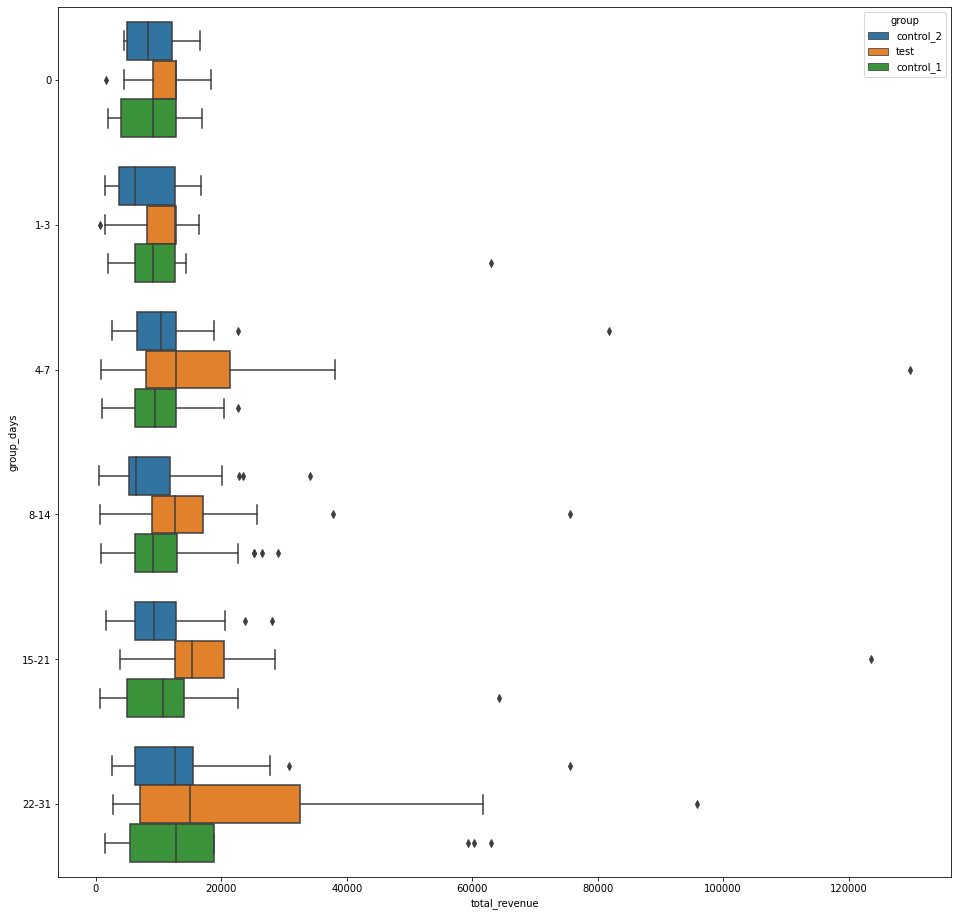

In [193]:
plt.figure(figsize=(16, 16))
sns.boxplot(data=data_days.query('total_revenue < 400000'),
            x='total_revenue', y='group_days', hue='group')

Следим, чтобы не осталось слишком маленьких выборок

In [194]:
data_days.groupby(['group', 'group_days'], as_index=False).agg({'uid':'count'}).sort_values('uid').head()

,group,group_days,uid
17,test,22-31,16
16,test,15-21,17
0,control_1,0,17
6,control_2,0,18
11,control_2,22-31,18


Теперь при помощи бутрэпа проверим 

\begin{equation*}
\begin{aligned} 
& H_0: \text{У пользователей с одинаковым кол-вом дней заходов в приложение medianRPPU в тестовой и контрольной группах равны}   \\
& H_a: \text{У этих же пользователей medianRPPU в тестовой и контрольной отличаются} \\
&            \text{и заодно выведем доверительные интервалы разницы этих различий} 
\end{aligned}
\end{equation*}

Выведем в таблице для каждой возрастной группы ее размер, p-val и доверительный интервал для сравнения тестовой группы с 1-м контролем и со вторым контролем 

In [199]:
days_b = do_boot_median(data_days, col='group_days', boot_it = 100000)

In [201]:
days_b

,group_days,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
0,0,"[17, 18, 19]","[9087.0, 8320.0, 12727.0]",0.0884,"[[-156.0], [6526.0]]",0.0884,"[[-52.0], [6435.0]]"
1,1-3,"[45, 46, 31]","[9139.0, 6292.0, 12597.0]",0.1436,"[[-767.0], [3367.0]]",0.0561,"[[0.0], [6142.5]]"
2,4-7,"[33, 30, 24]","[9490.0, 10354.5, 12727.0]",0.1421,"[[-650.0], [8125.0]]",0.1592,"[[-2398.5], [7208.5]]"
3,8-14,"[45, 41, 39]","[9087.0, 6461.0, 12597.0]",0.0662,"[[-845.0], [6097.0]]",0.0200,"[[377.0], [7436.0]]"
4,15-21,"[31, 34, 17]","[10686.0, 9301.5, 15392.0]",0.0170,"[[507.0], [10283.0]]",0.0066,"[[1508.0], [8814.1625]]"
5,22-31,"[20, 18, 16]","[12818.0, 12623.0, 15060.5]",0.3913,"[[-3601.0], [15580.5]]",0.3913,"[[-3874.0], [17186.0]]"


In [202]:
days_b.loc[(days_b['p-val [t, c1]'] < 0.05) | (days_b['p-val [t, c2]'] < 0.05)]

,group_days,"cnt_users[c1, c2, t]","medianRPPU[c1, c2, t]","p-val [t, c1]","ci [t, c1]","p-val [t, c2]","ci [t, c2]"
3,8-14,"[45, 41, 39]","[9087.0, 6461.0, 12597.0]",0.0662,"[[-845.0], [6097.0]]",0.0200,"[[377.0], [7436.0]]"
4,15-21,"[31, 34, 17]","[10686.0, 9301.5, 15392.0]",0.0170,"[[507.0], [10283.0]]",0.0066,"[[1508.0], [8814.1625]]"


> **Делаем выводы для 5% уровне значимости:**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается и с 1-й и со 2-й контрольной группой для категории пользователей, заходящих в приложение в первый месяц после регистрации 15-21 день - тестовые значения больше в среднем на соответветсвенно $[507; 10283]$ и $[1508; 8814]$ ден. ед.;**
>- **У пользователей в тестовой группе medianRPPU статистически значимо различается только со 2-й контрольной группой для категории пользователей, заходящих в приложение в первый месяц после регистрации 8-14 дней - тестовые значения больше в среднем на $[377; 7436]$ ден. ед.**

# 6. Итоги и выводы

После исследования структуры и наполнения данных, проведя оценку качества сплитования и протестировав несколько гипоетз, мы можем сделать вывод об успешности нововведений в дейтинговом приложении. После изменения стоимости премиум подписки для новых пользователей из нескольких стран мы, видим статистически значимое увеличение одной из ключевых наших метрик - в тестовой группе по сравнению с обеими контрольными вырос medianRPPU:
>- *В тестовой группе medianRPPU выше чем в 1-й контрольной группе в среднем на $[936; 3952]$ ден. единиц;*
>- *В тестовой группе medianRPPU выше чем во 2-й контрольной группе в среднем на $[1664; 5031]$ ден. единиц.*

При этом наблюдаем так же статистически значимое увеличение медианного дохода с премиум-подписки:
>- *В тестовой группе медианный доход с оформления подписок выше чем в 1-й контрольной группе в среднем на $[1625; 3048]$ ден. единиц;*
>- *В тестовой группе медианный доход с оформления подписок выше чем во 2-й контрольной группе в среднем на $[1534; 2925]$ ден. единиц.*

Одноврменно с этим CR в продление подписки значимо уменьшился по сравнению с сontrol_1 в среднем на $[1.12; 14.84]$ процентных пункта(статистически значимых различий с сontrol_1 не обнаружено), однако обычная конверсия в подписку значимо не изменилась.

Анализируя целесообразность введение новинки для конкрентых групп пользователей отметим некоторые найденные инетерсные закономерности: medianRPPU статистически значимо вырос по сравнению с одной или обоими сразу контрольными группами:
>- *У пользователей из Франции, Израиля, Бельгии и США*
>- *У пользователей возрастной категории 20-25 и 31-35*
>- *У пользователей заходящих в приложение в первый месяц после регистрации 15-21 дней и 8-14 дней*

Соответвенно для пользователей, чей медианный доход статистически значимо увеличился, изменения доказано целесообразны

Также нельзя не отметить, что на будущее команде приложения следуе тобратить внимание на исправление ошибок в системе сбора и хранения данных, чтобы устранить нижеперечисленные проблемы, которые пришлось дорабатывать вручную:
0. Отсутвие в таблицах users данных о некоторых транзакциях - нарушение согласованности данных - надо срочно чинить
1. Наличие пустых строк в transactions_control_1 - скорее всего какой-то баг, но возможно, что какие-то данные потерялись
2. Наличие дубликатов в таблицах транзакций - избавиться от них не сложно, но вот хранить лишнюю информацию точно не стоит
3. Несоблюдение равенства временных рамок эксперимента - хорошо, что заметил и пользователей за рамками было не много 

[Содержание](#Содержание)